# Install required packages

In [16]:
!pip install python-binance
!pip install catboost
!pip install matplotlib --upgrade
!pip install mpl_finance
!pip install --upgrade mplfinance

In [1]:
import pandas as pd
import numpy as np

import time
import dateparser
import pytz
import json

import math  

import datetime as dt
from datetime import datetime, timedelta

from threading import Thread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from mpl_finance import candlestick_ochl



from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

from tqdm import tqdm as tqdm

from binance.client import Client

import datetime as dtt

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


# Define Financial Indicators


In [7]:
def moving_average(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
  df = df.join(MA)
  return df

In [8]:
def exponential_moving_average(df, n):
  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
  df = df.join(EMA)
  return df

In [9]:
def momentum(df, n):
  M = pd.Series(df['Close'].diff(n), name="Momentum_"+str(n))
  df = df.join(M)
  return df

In [10]:
def bollinger_bands(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
  MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
  b1 = 4 * MSD / MA
  B1 = pd.Series(b1, name = "BollingerB_" + str(n))
  df = df.join(B1)
  b2 = (df['Close'] - MA  + 2 * MSD) / (4 * MSD)
  B2 = pd.Series(b2, name='Bollinger%b_'+str(n))
  df = df.join(B2)
  return df

In [11]:
def stochastic_oscillator(df ,n):
  S0K = pd.Series((df['Close']- df['Low']) / (df['High']-df['Low']), name='S0k_' + str(n))
  df = df.join(S0K)
  return df

In [12]:
def relative_strength_index(df, n):
  i = 0
  UpI = [0]
  DoI = [0]

  while i + 1 <= df.index[-1]:
    UpMove = df.loc[i+1, 'High'] - df.loc[i, 'High']
    DoMove = df.loc[i+1, 'Low'] - df.loc[i, 'Low']
    if UpMove > DoMove and UpMove > 0:
      UpD = UpMove
    else:
      UpD = 0
    UpI.append(UpD)
    if DoMove > UpMove and DoMove > 0:
      DoD = DoMove
    else:
      DoD = 0
    DoI.append(DoD)
    i = i + 1

  UpI = pd.Series(UpI)
  DoI = pd.Series(DoI)
  PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
  NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
  RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
  df = df.join(RSI)
  return df

In [13]:
def common_channel_index(df, n):
  PP = (df['High'] + df['Low'] + df['Close']) / 3
  CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(), name='CCI_' + str(n))
  df = df.join(CCI)
  return df

In [14]:
def standart_deviation(df, n):
  df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
  return df

# Define Binance Helper Functions

In [43]:
def binanceDataFrame(klines):
  df = pd.DataFrame(klines.reshape(-1,12), dtype=float, columns=['Open Time',
                                                                 'Open',
                                                                 'High',
                                                                 'Low',
                                                                 'Close',
                                                                 'Volume',
                                                                 'Close Time',
                                                                 'Quote asset volume',
                                                                 'Number of trades',
                                                                 'Taker buy base asset volume',
                                                                 'Taker buy quote asset volume',
                                                                 'Can be ignored']);

  df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
  df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

  return df

In [44]:
def date_to_miliseconds(date_str):
  epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
  d = dateparser.parse(date_str)
  if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
    d = d.replace(tzinfo=pytz.utc)

  #return difference in time
  return int((d - epoch).total_seconds()*1000.0)

In [45]:
def interval_to_miliseconds(interval):
  ms = None
  seconds_per_unit = {
      "m": 60,
      "h": 60 * 60,
      "d": 24 * 60 * 60,
      "w": 7 * 24 * 60 * 60,
  }

  unit = interval[-1]
  if unit in seconds_per_unit:
    try:
      ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
    except:
      pass

  return ms

In [46]:
def get_historical_klines(symbol, interval, start_str, end_str=None):
  output_data=[]
  limit=500
  timeFrame = interval_to_miliseconds(interval)
  start_ts = date_to_miliseconds(start_str)
  end_ts = None
  if end_str:
    end_ts = date_to_miliseconds(end_str)
  
  idx = 0
  symbol_existed = False
  while True:
    #fetch
    temp_data = client.get_klines(symbol = symbol, 
                                  interval = interval, 
                                  limit = limit, 
                                  startTime = start_ts, 
                                  endTime = end_ts)
    
    if not symbol_existed and len(temp_data):
      symbol_existed = True

    if symbol_existed:
      output_data += temp_data

      start_ts = temp_data[len(temp_data) - 1][0] + timeFrame

    idx += 1

    if len(temp_data)<limit:
      break

    if idx % 3 == 0:
      time.sleep(1)

  return output_data

# Construct Binance Client

In [48]:
api_key = ''
api_secret = ''
client = Client(api_key, api_secret)

# Get Market Depth

In [49]:
depth = client.get_order_book(symbol = 'BTCEUR')

In [50]:
depth

{'lastUpdateId': 1074265582,
 'bids': [['47135.63000000', '0.00425500'],
  ['47135.62000000', '0.06185900'],
  ['47134.47000000', '0.66096900'],
  ['47134.03000000', '0.14615300'],
  ['47131.86000000', '0.00405000'],
  ['47130.76000000', '0.11173300'],
  ['47130.71000000', '0.01722000'],
  ['47128.94000000', '0.00023200'],
  ['47126.00000000', '0.04779500'],
  ['47123.52000000', '0.16960100'],
  ['47122.02000000', '0.20000000'],
  ['47121.54000000', '0.13250100'],
  ['47121.29000000', '0.05208900'],
  ['47118.33000000', '0.00230500'],
  ['47118.32000000', '1.31352100'],
  ['47116.80000000', '0.10721000'],
  ['47116.59000000', '0.02106200'],
  ['47115.00000000', '0.01591800'],
  ['47114.77000000', '0.19600000'],
  ['47114.02000000', '0.00497100'],
  ['47114.00000000', '0.01061200'],
  ['47112.68000000', '0.13255700'],
  ['47111.40000000', '0.86994800'],
  ['47110.00000000', '0.04242600'],
  ['47109.57000000', '0.06496100'],
  ['47107.67000000', '0.20329700'],
  ['47106.60000000', '0.001

# Get BTCUSD 1DAY from Dataset

In [51]:
df_hist = pd.read_csv("BTCUSD_day.csv")
df_hist.head()

Date  Symbol     Open     High      Low    Close  Volume BTC  \
0  2020-04-10  BTCUSD  7315.25  7315.25  7315.25  7315.25        0.00   
1  2020-04-09  BTCUSD  7369.60  7378.85  7115.04  7315.25     2237.13   
2  2020-04-08  BTCUSD  7201.81  7432.23  7152.80  7369.60     2483.60   
3  2020-04-07  BTCUSD  7336.96  7468.42  7078.00  7201.81     2333.34   
4  2020-04-06  BTCUSD  6775.21  7369.76  6771.01  7336.96     3727.47   

    Volume USD  
0         0.00  
1  16310014.53  
2  18138080.27  
3  17047120.32  
4  26533750.17

In [52]:
df_hist.drop(0,inplace=True)

In [53]:
df_hist.tail()

Date  Symbol    Open    High    Low   Close  Volume BTC  \
1642  2015-10-12  BTCUSD  249.50  249.50  247.6  247.60       38.28   
1643  2015-10-11  BTCUSD  246.30  249.50  246.3  249.50       12.22   
1644  2015-10-10  BTCUSD  245.39  246.30  244.6  246.30       12.17   
1645  2015-10-09  BTCUSD  243.95  249.97  243.6  245.39       30.99   
1646  2015-10-08  BTCUSD  242.50  245.00  242.5  243.95       18.80   

      Volume USD  
1642     9493.89  
1643     3021.12  
1644     2984.44  
1645     7651.63  
1646     4595.84

In [54]:
df_n_trades = pd.read_csv("Bitcoin_dataset_updated.csv")
df_n_trades.head()

Date  BTC price [USD]  n-transactions  fee [USD]  btc search trends  \
0  2014-01-02           749.27         54770.0       0.18                  8   
1  2014-01-03           781.23         60980.0        NaN                  8   
2  2014-01-04           807.39         52052.0        NaN                  8   
3  2014-01-05           828.74         58662.0       0.38                  8   
4  2014-01-06           904.98         67358.0        NaN                  8   

   Gold price[USD]  SP500 close index  Oil WTI price[USD]  \
0           1225.0            1831.98               95.14   
1           1238.4            1831.37               93.66   
2              NaN                NaN                 NaN   
3              NaN                NaN                 NaN   
4           1237.8            1826.77               93.12   

   M2(Not seasonally adjusted)[1e+09 USD]  
0                                 11089.3  
1                                 11089.3  
2                                 11089.3  
3                                 11089.3  
4                                 11089.3

In [55]:
df_n_trades['Open Time'] = pd.to_datetime(df_n_trades['Date'])

In [56]:
df_n_trades = df_n_trades[["Open Time", "n-transactions"]]

# Get BTCUSD 1DAY from Binance

In [57]:
%%time
symbol = "BTCUSDT"
start = "10 Apr 2020"
interval = Client.KLINE_INTERVAL_1DAY
klines = get_historical_klines(symbol,interval,start)
klines = np.array(klines)
df = binanceDataFrame(klines)

Wall time: 2.8 s


In [58]:
%%time
symbol = "ETHUSDT"
start = "1 Jan, 2017"
interval = Client.KLINE_INTERVAL_1DAY
klines = get_historical_klines(symbol,interval,start)
klines = np.array(klines)
df_eth = binanceDataFrame(klines)

Wall time: 1.46 s


In [59]:
df_hist.rename(inplace=True, columns={"Date": "Open Time", "Volume USD":"Volume"})
df_hist['Open Time'] = pd.to_datetime(df_hist['Open Time'])

In [60]:
df_hist.dtypes

Open Time     datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume BTC           float64
Volume               float64
dtype: object

In [61]:
df_hist.describe()

Open          High           Low         Close    Volume BTC  \
count   1646.000000   1646.000000   1646.000000   1646.000000   1646.000000   
mean    4821.979399   4969.659514   4654.719957   4826.085182   3791.659526   
std     3938.457802   4079.357169   3760.906268   3937.222289   4437.060196   
min      242.500000    245.000000    236.000000    243.950000      0.000000   
25%      741.907500    751.750000    731.955000    742.185000   1032.590000   
50%     4146.105000   4288.345000   3997.500000   4150.970000   2263.775000   
75%     7920.570000   8144.625000   7633.167500   7920.570000   4920.277500   
max    19499.990000  19999.000000  18870.000000  19499.990000  49229.150000   

             Volume  
count  1.646000e+03  
mean   2.130419e+07  
std    3.695718e+07  
min    0.000000e+00  
25%    1.662455e+06  
50%    9.395500e+06  
75%    2.465518e+07  
max    5.606539e+08

In [62]:
df.dtypes

Open Time                       datetime64[ns]
Open                                   float64
High                                   float64
Low                                    float64
Close                                  float64
Volume                                 float64
Close Time                      datetime64[ns]
Quote asset volume                     float64
Number of trades                       float64
Taker buy base asset volume            float64
Taker buy quote asset volume           float64
Can be ignored                         float64
dtype: object

In [63]:
df.describe()

Open          High           Low         Close         Volume  \
count    376.000000    376.000000    376.000000    376.000000     376.000000   
mean   22487.345718  23211.588963  21752.081755  22618.504441   72101.972180   
std    17433.688516  18063.273508  16748.405031  17504.291914   33487.667413   
min     6621.250000   6903.790000   6468.270000   6621.240000   22298.221341   
25%     9684.545000   9871.437500   9447.582500   9694.712500   48205.334180   
50%    11852.970000  12029.230000  11651.015000  11873.235000   65360.304447   
75%    33974.435000  35696.082500  32202.792500  34101.480000   85408.678045   
max    63575.010000  64854.000000  62020.000000  63575.000000  249131.539943   

       Quote asset volume  Number of trades  Taker buy base asset volume  \
count        3.760000e+02      3.760000e+02                   376.000000   
mean         1.727710e+09      1.303532e+06                 35171.738955   
std          1.606320e+09      7.560362e+05                 16504.551739   
min          2.066281e+08      3.210150e+05                 10318.024614   
25%          5.164001e+08      6.770992e+05                 23278.350081   
50%          9.441905e+08      1.047274e+06                 31851.454197   
75%          2.789873e+09      1.807346e+06                 42001.965191   
max          8.426880e+09      4.431451e+06                122133.406190   

       Taker buy quote asset volume  Can be ignored  
count                  3.760000e+02           376.0  
mean                   8.492094e+08             0.0  
std                    7.958676e+08             0.0  
min                    9.992165e+07             0.0  
25%                    2.527622e+08             0.0  
50%                    4.513490e+08             0.0  
75%                    1.375136e+09             0.0  
max                    4.133116e+09             0.0

In [64]:
df_n_trades.dtypes

Open Time         datetime64[ns]
n-transactions           float64
dtype: object

In [65]:
df_total = pd.concat([df_hist, df])

In [66]:
df_total = df_total.merge(df_n_trades, how="left", on="Open Time")

In [67]:
df_total["Number of trades"] = df_total["Number of trades"].fillna(0)
df_total["n-transactions"] = df_total["n-transactions"].fillna(0)

In [68]:
df_total["NumberTransactions"] = df_total["Number of trades"] + df_total["n-transactions"]

In [69]:
df_total.describe()

Open          High          Low         Close    Volume BTC  \
count   2022.000000   2022.000000   2022.00000   2022.000000   1646.000000   
mean    8106.933769   8361.828393   7834.05133   8134.665618   3791.659526   
std    10783.475727  11157.289129  10384.30352  10835.839725   4437.060196   
min      242.500000    245.000000    236.00000    243.950000      0.000000   
25%     1042.565000   1069.747500   1017.91750   1045.017500   1032.590000   
50%     6407.170000   6538.165000   6317.92000   6408.720000   2263.775000   
75%     9477.060000   9699.045000   9230.19750   9479.777500   4920.277500   
max    63575.010000  64854.000000  62020.00000  63575.000000  49229.150000   

             Volume  Quote asset volume  Number of trades  \
count  2.022000e+03        3.760000e+02      2.022000e+03   
mean   1.735599e+07        1.727710e+09      2.423976e+05   
std    3.435111e+07        1.606320e+09      6.028294e+05   
min    0.000000e+00        2.066281e+08      0.000000e+00   
25%    3.094160e+05        5.164001e+08      0.000000e+00   
50%    5.244460e+06        9.441905e+08      0.000000e+00   
75%    2.000651e+07        2.789873e+09      0.000000e+00   
max    5.606539e+08        8.426880e+09      4.431451e+06   

       Taker buy base asset volume  Taker buy quote asset volume  \
count                   376.000000                  3.760000e+02   
mean                  35171.738955                  8.492094e+08   
std                   16504.551739                  7.958676e+08   
min                   10318.024614                  9.992165e+07   
25%                   23278.350081                  2.527622e+08   
50%                   31851.454197                  4.513490e+08   
75%                   42001.965191                  1.375136e+09   
max                  122133.406190                  4.133116e+09   

       Can be ignored  n-transactions  NumberTransactions  
count           376.0     2022.000000        2.022000e+03  
mean              0.0   216829.524728        4.592271e+05  
std               0.0   115315.553212        5.248995e+05  
min               0.0        0.000000        1.045500e+05  
25%               0.0   182180.750000        2.235690e+05  
50%               0.0   237427.500000        2.837955e+05  
75%               0.0   300016.500000        3.527665e+05  
max               0.0   490644.000000        4.431451e+06

In [109]:
df_total[["Open Time", "Open", "High", "Low", "Close", "Volume", "NumberTransactions"]].to_csv("btcusd-2015_2021.csv")

In [70]:
sp500 = pd.read_csv("Datos históricos S&P 500.csv")
sp500.head()

Fecha    Último  Apertura    Máximo    Mínimo Vol.  % var.
0  19.04.2021  4.162,80  4.175,60  4.180,02  4.150,54    -  -0,54%
1  16.04.2021  4.185,47  4.174,14  4.191,31  4.170,75    -   0,36%
2  15.04.2021  4.170,42  4.139,76  4.173,49  4.139,76    -   1,11%
3  14.04.2021  4.124,66  4.141,58  4.151,69  4.120,87    -  -0,41%
4  13.04.2021  4.141,59  4.130,10  4.148,00  4.124,43    -   0,33%

In [71]:
sp500['Open Time'] = pd.to_datetime(sp500['Fecha'])

In [72]:
df_with_index = df_total.merge(sp500[["Último", "Apertura", "Open Time"]], on="Open Time", how="left")

In [73]:
df_with_index.head()

Open Time  Symbol     Open     High      Low    Close  Volume BTC  \
0 2020-04-09  BTCUSD  7369.60  7378.85  7115.04  7315.25     2237.13   
1 2020-04-08  BTCUSD  7201.81  7432.23  7152.80  7369.60     2483.60   
2 2020-04-07  BTCUSD  7336.96  7468.42  7078.00  7201.81     2333.34   
3 2020-04-06  BTCUSD  6775.21  7369.76  6771.01  7336.96     3727.47   
4 2020-04-05  BTCUSD  6870.20  6907.90  6678.60  6775.21     1275.49   

        Volume Close Time  Quote asset volume  Number of trades  \
0  16310014.53        NaT                 NaN               0.0   
1  18138080.27        NaT                 NaN               0.0   
2  17047120.32        NaT                 NaN               0.0   
3  26533750.17        NaT                 NaN               0.0   
4   8662210.80        NaT                 NaN               0.0   

   Taker buy base asset volume  Taker buy quote asset volume  Can be ignored  \
0                          NaN                           NaN             NaN   
1                          NaN                           NaN             NaN   
2                          NaN                           NaN             NaN   
3                          NaN                           NaN             NaN   
4                          NaN                           NaN             NaN   

   n-transactions  NumberTransactions    Último  Apertura  
0        286706.0            286706.0  3.426,96  3.453,60  
1        286563.0            286563.0  3.306,51  3.289,92  
2        312770.0            312770.0       NaN       NaN  
3        280470.0            280470.0  3.112,35  3.111,56  
4        240259.0            240259.0  2.842,74  2.815,01

In [75]:
df_with_index.describe()

Open          High          Low         Close    Volume BTC  \
count   2022.000000   2022.000000   2022.00000   2022.000000   1646.000000   
mean    8106.933769   8361.828393   7834.05133   8134.665618   3791.659526   
std    10783.475727  11157.289129  10384.30352  10835.839725   4437.060196   
min      242.500000    245.000000    236.00000    243.950000      0.000000   
25%     1042.565000   1069.747500   1017.91750   1045.017500   1032.590000   
50%     6407.170000   6538.165000   6317.92000   6408.720000   2263.775000   
75%     9477.060000   9699.045000   9230.19750   9479.777500   4920.277500   
max    63575.010000  64854.000000  62020.00000  63575.000000  49229.150000   

             Volume  Quote asset volume  Number of trades  \
count  2.022000e+03        3.760000e+02      2.022000e+03   
mean   1.735599e+07        1.727710e+09      2.423976e+05   
std    3.435111e+07        1.606320e+09      6.028294e+05   
min    0.000000e+00        2.066281e+08      0.000000e+00   
25%    3.094160e+05        5.164001e+08      0.000000e+00   
50%    5.244460e+06        9.441905e+08      0.000000e+00   
75%    2.000651e+07        2.789873e+09      0.000000e+00   
max    5.606539e+08        8.426880e+09      4.431451e+06   

       Taker buy base asset volume  Taker buy quote asset volume  \
count                   376.000000                  3.760000e+02   
mean                  35171.738955                  8.492094e+08   
std                   16504.551739                  7.958676e+08   
min                   10318.024614                  9.992165e+07   
25%                   23278.350081                  2.527622e+08   
50%                   31851.454197                  4.513490e+08   
75%                   42001.965191                  1.375136e+09   
max                  122133.406190                  4.133116e+09   

       Can be ignored  n-transactions  NumberTransactions  
count           376.0     2022.000000        2.022000e+03  
mean              0.0   216829.524728        4.592271e+05  
std               0.0   115315.553212        5.248995e+05  
min               0.0        0.000000        1.045500e+05  
25%               0.0   182180.750000        2.235690e+05  
50%               0.0   237427.500000        2.837955e+05  
75%               0.0   300016.500000        3.527665e+05  
max               0.0   490644.000000        4.431451e+06

# Preporcessing

In [76]:
df_eth['Open Time']-dtt.timedelta(days=1)

0      2017-08-16
1      2017-08-17
2      2017-08-18
3      2017-08-19
4      2017-08-20
          ...    
1338   2021-04-15
1339   2021-04-16
1340   2021-04-17
1341   2021-04-18
1342   2021-04-19
Name: Open Time, Length: 1343, dtype: datetime64[ns]

In [36]:
for i, b in df.iterrows():
    print(i)
    if i == 0:
        df.loc[i, 'eth_previous_close'] = 0
    else:
        df.loc[i, 'eth_previous_close'] = df_eth.loc[(i-1), 'Close']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
df = df_with_index.copy()

In [78]:
remove_cols = [c for c in df.columns if c not in ['Open','Close','High','Low','Volume','Open Time', 'NumberTransactions', "Último", "Apertura"]]
df.drop(remove_cols, axis=1, inplace=True)

In [79]:
df = df.sort_values(by="Open Time").reset_index()

In [80]:
df.drop("index", axis=1, inplace=True)

In [81]:
df.head()

Open Time    Open    High    Low   Close   Volume  NumberTransactions  \
0 2015-10-08  242.50  245.00  242.5  243.95  4595.84            140348.0   
1 2015-10-09  243.95  249.97  243.6  245.39  7651.63            114644.0   
2 2015-10-10  245.39  246.30  244.6  246.30  2984.44            127005.0   
3 2015-10-11  246.30  249.50  246.3  249.50  3021.12            104550.0   
4 2015-10-12  249.50  249.50  247.6  247.60  9493.89            134410.0   

     Último  Apertura  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3  2.081,72  2.077,19  
4  2.052,23  2.047,93

In [82]:
#df.to_csv("btcusd-2015_2021.csv")
df.tail()

Open Time      Open      High       Low     Close         Volume  \
2017 2021-04-16  63158.74  63520.61  60000.00  61334.80   91764.139884   
2018 2021-04-17  61334.81  62506.05  59580.91  60006.66   58912.256128   
2019 2021-04-18  60006.67  60499.00  50931.30  56150.01  124882.131824   
2020 2021-04-19  56150.01  57526.81  54221.58  55633.14   78229.042267   
2021 2021-04-20  55633.14  56599.53  53329.96  56566.46   60500.152593   

      NumberTransactions    Último  Apertura  
2017           2639940.0  4.185,47  4.174,14  
2018           2268816.0       NaN       NaN  
2019           3444089.0       NaN       NaN  
2020           2390527.0  4.162,80  4.175,60  
2021           1750083.0       NaN       NaN

In [87]:
df.dtypes

Open Time             datetime64[ns]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
NumberTransactions           float64
Último                        object
Apertura                      object
dtype: object

In [84]:
df.isna().sum()

Open Time               0
Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
NumberTransactions      0
Último                670
Apertura              670
dtype: int64

In [96]:
df_fill = df.fillna(method="ffill")
df_fill[df_fill["Open Time"] == '2021-04-18']

Open Time      Open     High      Low     Close         Volume  \
2019 2021-04-18  60006.67  60499.0  50931.3  56150.01  124882.131824   

      NumberTransactions    Último  Apertura  
2019           3444089.0  4.185,47  4.174,14

In [101]:
df_fill = df_fill.dropna()
df = df_fill.copy()

In [103]:
df["Último"] = df["Último"].apply(lambda x: x.replace(".", ""))
df["Último"] = df["Último"].apply(lambda x: x.replace(",", "."))

In [104]:
df["Apertura"] = df["Apertura"].apply(lambda x: x.replace(".", ""))
df["Apertura"] = df["Apertura"].apply(lambda x: x.replace(",", "."))

In [105]:
df["Último"] = df["Último"].astype(float)
df["Apertura"] = df["Apertura"].astype(float)

In [111]:
df.rename(columns={"Último":"Close SP500", "Apertura":"Open SP500"}, inplace=True)

In [112]:
df.columns.values

array(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'NumberTransactions', 'Close SP500', 'Open SP500'], dtype=object)

In [113]:
df.to_csv("btcusd-2015_2021_sp500.csv")

#### Halving

In [114]:
#df = pd.read_csv("btcusd-2015_2021.csv", index_col=0)
df.head()

Open Time   Open    High     Low   Close    Volume  NumberTransactions  \
3 2015-10-11  246.3  249.50  246.30  249.50   3021.12            104550.0   
4 2015-10-12  249.5  249.50  247.60  247.60   9493.89            134410.0   
5 2015-10-13  247.6  252.87  245.75  250.00  12875.40            134878.0   
6 2015-10-14  250.0  254.75  250.00  253.00  30115.77            141985.0   
7 2015-10-15  253.0  258.98  253.00  255.26  50535.45            153495.0   

   Close SP500  Open SP500  
3      2081.72     2077.19  
4      2052.23     2047.93  
5      2003.69     2015.00  
6      1994.24     2003.66  
7      2023.86     1996.47

In [115]:
df["halving"] =3

In [116]:
df.loc[df["Open Time"] <= "2016-07-09", "halving"] = 2

In [117]:
df.loc[df["Open Time"] <= "2020-05-11", "halving"] = 1

In [118]:
df[df["Open Time"] == "2021-04-09"]

Open Time      Open     High      Low     Close        Volume  \
2010 2021-04-09  58077.52  58894.9  57654.0  58142.54  40831.884911   

      NumberTransactions  Close SP500  Open SP500  halving  
2010           1615962.0      3768.47     3818.53        3

In [119]:
df.to_csv("btcusd-2015_2021_sp500_halving.csv")

#### Oro

In [120]:
oro = pd.read_csv("oro.csv")
oro.head()

Fecha    Último  Apertura    Máximo    Mínimo   Vol.  % var.
0  19.04.2021  1.769,40  1.782,10  1.788,50  1.771,40  0,14K  -0,54%
1  16.04.2021  1.779,00  1.770,40  1.779,50  1.770,10  0,63K   0,77%
2  15.04.2021  1.765,40  1.740,10  1.767,90  1.740,10  0,37K   1,76%
3  14.04.2021  1.734,90  1.741,30  1.745,90  1.732,70  1,04K  -0,65%
4  13.04.2021  1.746,20  1.733,80  1.746,90  1.722,10  0,37K   0,87%

In [121]:
oro['Open Time'] = pd.to_datetime(oro['Fecha'])

In [122]:
df['Open Time'] = pd.to_datetime(df['Open Time'])

In [123]:
df = df.merge(oro[["Último", "Apertura", "Open Time"]], on="Open Time", how="left")

In [124]:
df.rename(columns={"Último":"Close Gold", "Apertura":"Open Gold"}, inplace=True)

In [125]:
df_fill = df.fillna(method="ffill")
df_fill = df_fill.dropna()
df = df_fill.copy()

In [126]:
df["Close Gold"] = df["Close Gold"].apply(lambda x: x.replace(".", ""))
df["Close Gold"] = df["Close Gold"].apply(lambda x: x.replace(",", "."))

df["Open Gold"] = df["Open Gold"].apply(lambda x: x.replace(".", ""))
df["Open Gold"] = df["Open Gold"].apply(lambda x: x.replace(",", "."))

In [127]:
df.to_csv("btcusd-2015_2021_sp500_halving_gold.csv")

In [130]:
df.describe()

Open          High           Low         Close        Volume  \
count   2019.000000   2019.000000   2019.000000   2019.000000  2.019000e+03   
mean    8118.617256   8373.885953   7845.329911   8146.388430  1.738177e+07   
std    10787.222476  11161.188328  10387.891407  10839.617374  3.437011e+07   
min      246.300000    249.500000    236.000000    247.600000  0.000000e+00   
25%     1049.880000   1082.560000   1022.655000   1054.860000  3.166145e+05   
50%     6410.010000   6546.290000   6320.010000   6412.000000  5.270744e+06   
75%     9479.285000   9699.530000   9231.755000   9484.275000  2.003407e+07   
max    63575.010000  64854.000000  62020.000000  63575.000000  5.606539e+08   

       NumberTransactions  Close SP500   Open SP500      halving  
count        2.019000e+03  2019.000000  2019.000000  2019.000000  
mean         4.597203e+05  2722.603843  2723.500594     1.340763  
std          5.251333e+05   506.494218   507.698068     0.752121  
min          1.045500e+05  1829.080000  1833.400000     1.000000  
25%          2.237780e+05  2341.890000  2342.610000     1.000000  
50%          2.838960e+05  2717.070000  2717.350000     1.000000  
75%          3.529245e+05  2986.200000  2988.865000     1.000000  
max          4.431451e+06  4185.470000  4175.600000     3.000000

## Calculate financial indicators for serveral windows

In [447]:
windows = [3,5,9,14,30,50,100,150,300]

In [448]:
%%time

for w in tqdm(windows):
  df = moving_average(df, w)
  df = exponential_moving_average(df, w)
  df = momentum(df,w)
  df = bollinger_bands(df,w)
  df = stochastic_oscillator(df,w)
  df = relative_strength_index(df,w)
  df = common_channel_index(df,w)
  df = standart_deviation(df,w)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.99it/s]

Wall time: 695 ms


In [33]:
df.describe()

Open          High           Low         Close        Volume  \
count   1293.000000   1293.000000   1293.000000   1293.000000  1.293000e+03   
mean    7186.604462   7424.262985   6923.364865   7204.229652  2.136881e+07   
std     9763.775719  10117.703013   9368.248005   9780.864730  3.791133e+07   
min      246.300000    249.500000    245.750000    247.600000  0.000000e+00   
25%      923.020000    941.190000    909.970000    923.870000  8.989992e+05   
50%     5517.210000   5648.040000   5290.000000   5538.250000  9.084856e+06   
75%     8761.750000   8932.160000   8477.510000   8745.750000  2.494082e+07   
max    63575.010000  64854.000000  62020.000000  63575.000000  5.606539e+08   

       NumberTransactions      halving  
count        1.293000e+03  1293.000000  
mean         3.977494e+05     1.947409  
std          4.667491e+05     0.477370  
min          1.045500e+05     1.000000  
25%          2.255290e+05     2.000000  
50%          2.780930e+05     2.000000  
75%          3.299430e+05     2.000000  
max          4.403349e+06     3.000000

In [450]:
df = df [['Open','Close','High','Low','Volume', 'NumberTransactions', "halving", 'MA_3', 'Momentum_3', 'BollingerB_3']]

In [451]:
df.corr()

Open     Close      High       Low    Volume  \
Open                1.000000  0.998606  0.999301  0.998777  0.028519   
Close               0.998606  1.000000  0.999428  0.999132  0.025804   
High                0.999301  0.999428  1.000000  0.998652  0.034491   
Low                 0.998777  0.999132  0.998652  1.000000  0.013655   
Volume              0.028519  0.025804  0.034491  0.013655  1.000000   
NumberTransactions  0.841950  0.842414  0.846095  0.835349 -0.163450   
halving             0.624777  0.625568  0.623226  0.627401 -0.033291   
MA_3                0.999686  0.999233  0.999519  0.998950  0.027874   
Momentum_3          0.179408  0.209905  0.194520  0.202491 -0.061119   
BollingerB_3        0.111957  0.113779  0.123398  0.099163  0.476701   

                    NumberTransactions   halving      MA_3  Momentum_3  \
Open                          0.841950  0.624777  0.999686    0.179408   
Close                         0.842414  0.625568  0.999233    0.209905   
High                          0.846095  0.623226  0.999519    0.194520   
Low                           0.835349  0.627401  0.998950    0.202491   
Volume                       -0.163450 -0.033291  0.027874   -0.061119   
NumberTransactions            1.000000  0.644207  0.841632    0.201672   
halving                       0.644207  1.000000  0.625077    0.124628   
MA_3                          0.841632  0.625077  1.000000    0.179880   
Momentum_3                    0.201672  0.124628  0.179880    1.000000   
BollingerB_3                  0.118635  0.029306  0.112544    0.017360   

                    BollingerB_3  
Open                    0.111957  
Close                   0.113779  
High                    0.123398  
Low                     0.099163  
Volume                  0.476701  
NumberTransactions      0.118635  
halving                 0.029306  
MA_3                    0.112544  
Momentum_3              0.017360  
BollingerB_3            1.000000

In [452]:
for i, b in df.iterrows():
    print(i)
    if i == 0:
        df.loc[i, 'NumberTransactions_PreviousDate'] = 0
    else:
        df.loc[i, 'NumberTransactions_PreviousDate'] = df.loc[(i-1), 'NumberTransactions']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [471]:
for i, b in df.iterrows():
    print(i)
    if i < 5:
        df.loc[i, 'NumberTransactions_FivePreviousDate'] = 0
    else:
        df.loc[i, 'NumberTransactions_FivePreviousDate'] = df.loc[(i-5), 'NumberTransactions']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [472]:
df.corr()

Open     Close      High       Low  \
Open                                 1.000000  0.998606  0.999301  0.998777   
Close                                0.998606  1.000000  0.999428  0.999132   
High                                 0.999301  0.999428  1.000000  0.998652   
Low                                  0.998777  0.999132  0.998652  1.000000   
Volume                               0.028519  0.025804  0.034491  0.013655   
NumberTransactions                   0.841950  0.842414  0.846095  0.835349   
halving                              0.624777  0.625568  0.623226  0.627401   
MA_3                                 0.999686  0.999233  0.999519  0.998950   
Momentum_3                           0.179408  0.209905  0.194520  0.202491   
BollingerB_3                         0.111957  0.113779  0.123398  0.099163   
NumberTransactions_PreviousDate      0.841769  0.842089  0.842832  0.839174   
NumberTransactions_FivePreviousDate  0.840442  0.840643  0.841213  0.838505   

                                       Volume  NumberTransactions   halving  \
Open                                 0.028519            0.841950  0.624777   
Close                                0.025804            0.842414  0.625568   
High                                 0.034491            0.846095  0.623226   
Low                                  0.013655            0.835349  0.627401   
Volume                               1.000000           -0.163450 -0.033291   
NumberTransactions                  -0.163450            1.000000  0.644207   
halving                             -0.033291            0.644207  1.000000   
MA_3                                 0.027874            0.841632  0.625077   
Momentum_3                          -0.061119            0.201672  0.124628   
BollingerB_3                         0.476701            0.118635  0.029306   
NumberTransactions_PreviousDate     -0.165483            0.938029  0.644831   
NumberTransactions_FivePreviousDate -0.164296            0.894141  0.648058   

                                         MA_3  Momentum_3  BollingerB_3  \
Open                                 0.999686    0.179408      0.111957   
Close                                0.999233    0.209905      0.113779   
High                                 0.999519    0.194520      0.123398   
Low                                  0.998950    0.202491      0.099163   
Volume                               0.027874   -0.061119      0.476701   
NumberTransactions                   0.841632    0.201672      0.118635   
halving                              0.625077    0.124628      0.029306   
MA_3                                 1.000000    0.179880      0.112544   
Momentum_3                           0.179880    1.000000      0.017360   
BollingerB_3                         0.112544    0.017360      1.000000   
NumberTransactions_PreviousDate      0.842179    0.175506      0.087079   
NumberTransactions_FivePreviousDate  0.840866    0.156003      0.046104   

                                     NumberTransactions_PreviousDate  \
Open                                                        0.841769   
Close                                                       0.842089   
High                                                        0.842832   
Low                                                         0.839174   
Volume                                                     -0.165483   
NumberTransactions                                          0.938029   
halving                                                     0.644831   
MA_3                                                        0.842179   
Momentum_3                                                  0.175506   
BollingerB_3                                                0.087079   
NumberTransactions_PreviousDate                             1.000000   
NumberTransactions_FivePreviousDate                         0.903987   

                                     NumberTransactions_FivePreviousDate

In [217]:
df.head()

Open   Close    High    Low   Volume  NumberTransactions        MA_3  \
0  242.50  243.95  245.00  242.5  4595.84            140348.0         NaN   
1  243.95  245.39  249.97  243.6  7651.63            114644.0         NaN   
2  245.39  246.30  246.30  244.6  2984.44            127005.0  245.213333   
3  246.30  249.50  249.50  246.3  3021.12            104550.0  247.063333   
4  249.50  247.60  249.50  247.6  9493.89            134410.0  247.800000   

   Momentum_3  BollingerB_3  NumberTransactions_PreviousDate  
0         NaN           NaN                              0.0  
1         NaN           NaN                         140348.0  
2         NaN      0.019329                         114644.0  
3        5.55      0.034950                         127005.0  
4        2.21      0.025978                         104550.0

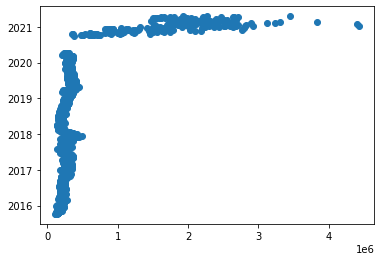

In [218]:
plt.scatter(df_total.NumberTransactions, df_total["Open Time"])

## Define Train Data

In [2]:
df = pd.read_csv('df_indexes_gold.csv')

In [5]:
windows = [3,5,8,10]

In [15]:
for w in tqdm(windows):
  df = moving_average(df, w)
  df = exponential_moving_average(df, w)
  df = momentum(df,w)
  df = bollinger_bands(df,w)
  df = stochastic_oscillator(df,w)
  df = relative_strength_index(df,w)
  df = common_channel_index(df,w)
  df = standart_deviation(df,w)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.20it/s]


In [21]:
df.drop(df.columns.values[0], axis=1, inplace=True)

In [22]:
df.drop('Open Time', axis=1, inplace=True)

In [46]:
X = df.drop(['Close', 'High', 'Low'], axis=1)
y = df['Close']

In [59]:
def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, :])
        dataY.append(dataset[i+look_back_memory, 3])
    return np.array(dataX), np.array(dataY)

In [63]:
dataX.shape

(2017, 1, 49)

## Clean Data

In [30]:
X = X[max(windows)+1:]
y = y[max(windows)+1:]
X.fillna(value=0, inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)

In [31]:
X

Open         Volume  NumberTransactions  Close SP500  Open SP500  \
11      271.64  162664.500000            147402.0      2052.51     2021.88   
12      276.89  164962.530000            143468.0      2075.15     2058.19   
13      280.20  123247.670000            140128.0      2075.15     2058.19   
14      285.00   13502.410000            131488.0      2075.15     2058.19   
15      289.38   97784.330000            116400.0      2071.18     2075.08   
...        ...            ...                 ...          ...         ...   
2014  63158.74   91764.139884           2639940.0      4185.47     4174.14   
2015  61334.81   58912.256128           2268816.0      4185.47     4174.14   
2016  60006.67  124882.131824           3444089.0      4185.47     4174.14   
2017  56150.01   78229.042267           2390527.0      4162.80     4175.60   
2018  55633.14   60500.152593           1750083.0      4162.80     4175.60   

      halving  Close Gold  Open Gold    OpenDJ   CloseDJ  ...        STD_8  \
11          1      1228.2     1228.2  17180.88  17489.16  ...     6.756520   
12          1      1218.7     1218.7  17525.11  17646.70  ...     4.954750   
13          1      1218.7     1218.7  17525.11  17646.70  ...     5.421043   
14          1      1218.7     1218.7  17525.11  17646.70  ...     7.304838   
15          1      1220.3     1220.3  17649.57  17623.05  ...     7.392666   
...       ...         ...        ...       ...       ...  ...          ...   
2014        3      1779.0     1770.4  34058.16  34200.67  ...  1969.124843   
2015        3      1779.0     1770.4  34058.16  34200.67  ...  1654.216869   
2016        3      1779.0     1770.4  34058.16  34200.67  ...  2447.700679   
2017        3      1769.4     1782.1  34182.38  34077.63  ...  3078.054362   
2018        3      1769.4     1782.1  34182.38  34077.63  ...  3358.157425   

          MA_10        EMA_10  Momentum_10  BollingerB_10  Bollinger%b_10  \
11      265.606    268.752903        29.29       0.143882        0.795270   
12      268.626    270.999616        30.20       0.131298        0.828154   
13      271.826    273.708317        32.00       0.122261        0.896404   
14      275.238    276.705438        34.12       0.112421        0.957039   
15      277.717    278.947597        24.79       0.109699        0.855255   
...         ...           ...          ...            ...             ...   
2014  60283.438  60836.588306      3343.65       0.165657        0.605280   
2015  60688.759  60685.692251      4053.21       0.131420        0.414478   
2016  60496.008  59861.022751     -1927.51       0.154582        0.035266   
2017  60245.068  59092.316796     -2509.40       0.180711        0.076381   
2018  59924.801  58633.070106     -3202.67       0.197702        0.216530   

        S0k_10    RSI_10    CCI_10       STD_10  
11    0.646857  0.793249  1.132256     9.553952  
12    0.468839  0.611368  1.366570     8.817506  
13    1.000000  0.525505  1.500358     8.308440  
14    0.365000  0.707858  1.966319     7.735666  
15    0.350000  0.707858  1.532563     7.616352  
...        ...       ...       ...          ...  
2014  0.379139  0.477199  0.611611  2496.593173  
2015  0.145549  0.477199  0.043054  1993.928453  
2016  0.545451  0.477199 -2.057734  2337.897916  
2017  0.427069  0.229498 -1.696622  2721.740960  
2018  0.989886  0.229498 -1.428552  2961.808663  

[2008 rows x 46 columns]

## Scaling

In [32]:
%%time
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

Wall time: 8 ms


In [67]:
scaler = StandardScaler()
scaler.fit(df)
df_scaler = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [92]:
df_scaler = df_scaler.dropna()

In [128]:
df_scaler

Open      High       Low     Close    Volume  NumberTransactions  \
10   -0.727570 -0.726011 -0.729475 -0.726658 -0.502966           -0.589561   
11   -0.727613 -0.725363 -0.729308 -0.726174 -0.501115           -0.594888   
12   -0.727126 -0.725007 -0.728763 -0.725869 -0.501048           -0.602382   
13   -0.726819 -0.724913 -0.728446 -0.725426 -0.502262           -0.608743   
14   -0.726374 -0.723838 -0.727982 -0.725021 -0.505456           -0.625201   
...        ...       ...       ...       ...       ...                 ...   
2014  5.103608  4.942161  5.021962  4.908069 -0.503178            4.152774   
2015  4.934484  4.851237  4.981607  4.785512 -0.504134            3.445875   
2016  4.811332  4.671369  4.148738  4.429632 -0.502214            5.684477   
2017  4.453722  4.405006  4.465559  4.381937 -0.503572            3.677705   
2018  4.405795  4.321905  4.379705  4.468061 -0.504088            2.457819   

      Close SP500  Open SP500   halving  Close Gold  ...     STD_8     MA_10  \
10      -1.389627   -1.359472 -0.453181   -1.039905  ... -0.596383 -0.737520   
11      -1.323332   -1.382307 -0.453181   -1.047032  ... -0.598437 -0.737242   
12      -1.278621   -1.310770 -0.453181   -1.092170  ... -0.601406 -0.736956   
13      -1.278621   -1.310770 -0.453181   -1.092170  ... -0.600638 -0.736653   
14      -1.278621   -1.310770 -0.453181   -1.092170  ... -0.597533 -0.736330   
...           ...         ...       ...         ...  ...       ...       ...   
2014     2.888934    2.857995  2.206623    1.569987  ...  2.635787  4.946305   
2015     2.888934    2.857995  2.206623    1.569987  ...  2.116780  4.984688   
2016     2.888934    2.857995  2.206623    1.569987  ...  3.424538  4.966435   
2017     2.844165    2.860872  2.206623    1.524375  ...  4.463438  4.942671   
2018     2.844165    2.860872  2.206623    1.524375  ...  4.925082  4.912343   

        EMA_10  Momentum_10  BollingerB_10  Bollinger%b_10    S0k_10  \
10   -0.738129    -0.148480      -0.209075        0.524672  0.286105   
11   -0.737936    -0.144618      -0.298225        0.777991  0.242909   
12   -0.737723    -0.144126      -0.399019        0.888841 -0.419754   
13   -0.737466    -0.143153      -0.471402        1.118911  1.557460   
14   -0.737182    -0.142008      -0.550217        1.323310 -0.806286   
...        ...          ...            ...             ...       ...   
2014  5.005264     1.645906      -0.123807        0.137534 -0.753655   
2015  4.990956     2.029233      -0.398041       -0.505657 -1.623180   
2016  4.912758    -1.201743      -0.212516       -1.783975 -0.134570   
2017  4.839868    -1.516099      -0.003224       -1.645379 -0.575240   
2018  4.796321    -1.890625       0.132867       -1.172939  1.519809   

        RSI_10    CCI_10    STD_10  
10    1.182607  0.492543 -0.602974  
11    1.666014  0.704695 -0.603908  
12    0.723556  0.896426 -0.605007  
13    0.278641  1.005900 -0.605766  
14    1.223541  1.387178 -0.606621  
...        ...       ...       ...  
2014  0.028333  0.278671  3.107648  
2015  0.028333 -0.186559  2.357491  
2016  0.028333 -1.905556  2.870817  
2017 -1.255186 -1.610072  3.443649  
2018 -1.255186 -1.390720  3.801916  

[2007 rows x 49 columns]

## Split Data

In [93]:
train_size = int(X.shape[0] * 0.7)
test_size = int(X.shape[0] * 0.15)
valid_size = int(X.shape[0] * 0.15)

In [94]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:(train_size + test_size)], y[:train_size], y[train_size:(train_size + test_size)]
X_valid, y_valid = X[(train_size + test_size):(train_size + test_size + valid_size)], y[(train_size + test_size):(train_size + test_size + valid_size)]

In [95]:
"""
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle = False)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, test_size=0.2, shuffle = True)
"""
print("Train", X_train.shape, y_train.shape)
print("Valid", X_valid.shape, y_valid.shape)
print("Test", X_test.shape, y_test.shape)

Train (1413, 46) (1413,)
Valid (302, 46) (302,)
Test (302, 46) (302,)


In [96]:
train_size = int(len(df_scaler) * 0.67)
test_size = len(df_scaler) - train_size
train, test = df_scaler[0:train_size], df_scaler[train_size:len(df_scaler)]

# Train

## LSTM

In [97]:
look_back_memory = 1
trainX, trainY = create_dataset(train.values, look_back_memory)
testX, testY = create_dataset(test.values, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1342, 1, 49) (1342,)
(661, 1, 49) (661,)


In [150]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(LSTM(100, input_shape=(1, 49)))
model.add(Dense(49, activation='relu'))
#model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_absolute_error", "mean_squared_error"])
model.fit(trainX, trainY, epochs=10000, batch_size=1, verbose=1)

Epoch 1/10000
1342/1342 [==============================] - 7s 4ms/step - loss: 0.2540 - mean_absolute_error: 0.4365 - mean_squared_error: 0.2540
Epoch 2/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2564 - mean_absolute_error: 0.4335 - mean_squared_error: 0.2564
Epoch 3/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2532 - mean_absolute_error: 0.4296 - mean_squared_error: 0.2532
Epoch 4/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2471 - mean_absolute_error: 0.4232 - mean_squared_error: 0.2471
Epoch 5/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2454 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2454
Epoch 6/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2477 - mean_absolute_error: 0.4219 - mean_squared_error: 0.2477
Epoch 7/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2503 - mean_absolute_error: 0.4254 - mean_squared

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2530 - mean_absolute_error: 0.4213 - mean_squared_error: 0.2530: 1s - ETA: 0s - loss: 0.2531 - mean_absolute_error: 0.4213 - mean_squared_error: 0.25
Epoch 109/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2371 - mean_absolute_error: 0.4051 - mean_squared_error: 0.2371
Epoch 110/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2476 - mean_absolute_error: 0.4204 - mean_squared_error: 0.2476
Epoch 111/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2412 - mean_absolute_error: 0.4077 - mean_squared_error: 0.2412
Epoch 112/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2480 - mean_absolute_error: 0.4182 - mean_squared_error: 0.2480
Epoch 113/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2433 - mean_absolute_error: 0.4115 - mean_squared_error: 0.2433
Epoch 114/10000
1342/1342 [=====================

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2425 - mean_absolute_error: 0.4111 - mean_squared_error: 0.2425: 0s - loss: 0.2421 - mean_absolute_error: 0.4107 - mean_squared
Epoch 218/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4225 - mean_squared_error: 0.2524
Epoch 219/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2522 - mean_absolute_error: 0.4209 - mean_squared_error: 0.2522
Epoch 220/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2450 - mean_absolute_error: 0.4111 - mean_squared_error: 0.2450
Epoch 221/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2474 - mean_absolute_error: 0.4129 - mean_squared_error: 0.2474
Epoch 222/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2505 - mean_absolute_error: 0.4197 - mean_squared_error: 0.2505: 1s - loss: 0.2510 
Epoch 223/10000
1342/1342 [=======================

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2519 - mean_absolute_error: 0.4238 - mean_squared_error: 0.2519
Epoch 271/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4140 - mean_squared_error: 0.2462
Epoch 272/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4125 - mean_squared_error: 0.2449
Epoch 273/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2535 - mean_absolute_error: 0.4248 - mean_squared_error: 0.2535
Epoch 274/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2481 - mean_absolute_error: 0.4191 - mean_squared_error: 0.2481
Epoch 275/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2442 - mean_absolute_error: 0.4144 - mean_squared_error: 0.2442
Epoch 276/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2444 - mean_absolute_error: 0.4124 - mean_squared_e

Epoch 324/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2509 - mean_absolute_error: 0.4200 - mean_squared_error: 0.2509
Epoch 325/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.4173 - mean_squared_error: 0.2473
Epoch 326/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2504 - mean_absolute_error: 0.4210 - mean_squared_error: 0.2504
Epoch 327/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2461 - mean_absolute_error: 0.4159 - mean_squared_error: 0.2461: 1s - loss: 0.2450 
Epoch 328/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2561 - mean_absolute_error: 0.4284 - mean_squared_error: 0.2561
Epoch 329/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2514 - mean_absolute_error: 0.4217 - mean_squared_error: 0.2514
Epoch 330/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2443 - mean_abs

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2445 - mean_absolute_error: 0.4150 - mean_squared_error: 0.2445
Epoch 380/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4109 - mean_squared_error: 0.2435: 0s - loss: 0.2430 - mean_absolute_error: 0
Epoch 381/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2507 - mean_absolute_error: 0.4213 - mean_squared_error: 0.2507
Epoch 382/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2511 - mean_absolute_error: 0.4204 - mean_squared_error: 0.2511
Epoch 383/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2394 - mean_absolute_error: 0.4041 - mean_squared_error: 0.2394
Epoch 384/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2492 - mean_absolute_error: 0.4184 - mean_squared_error: 0.2492
Epoch 385/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2472 - 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2539 - mean_absolute_error: 0.4254 - mean_squared_error: 0.2539
Epoch 486/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2457 - mean_absolute_error: 0.4163 - mean_squared_error: 0.2457
Epoch 487/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2498 - mean_absolute_error: 0.4182 - mean_squared_error: 0.2498
Epoch 488/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4104 - mean_squared_error: 0.2436
Epoch 489/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2532 - mean_absolute_error: 0.4258 - mean_squared_error: 0.2532
Epoch 490/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2489 - mean_absolute_error: 0.4185 - mean_squared_error: 0.2489
Epoch 491/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2424 - mean_absolute_error: 0.4090 - mean_squared_e

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2511 - mean_absolute_error: 0.4200 - mean_squared_error: 0.2511
Epoch 595/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4154 - mean_squared_error: 0.2479
Epoch 596/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2457 - mean_absolute_error: 0.4165 - mean_squared_error: 0.2457
Epoch 597/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2540 - mean_absolute_error: 0.4237 - mean_squared_error: 0.2540
Epoch 598/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2501 - mean_absolute_error: 0.4181 - mean_squared_error: 0.2501
Epoch 599/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2335 - mean_absolute_error: 0.4005 - mean_squared_error: 0.2335
Epoch 600/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4132 - mean_squared_e

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2509 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2509
Epoch 701/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2396 - mean_absolute_error: 0.4061 - mean_squared_error: 0.2396
Epoch 702/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2545 - mean_absolute_error: 0.4249 - mean_squared_error: 0.2545
Epoch 703/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2489 - mean_absolute_error: 0.4172 - mean_squared_error: 0.2489
Epoch 704/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2530 - mean_absolute_error: 0.4250 - mean_squared_error: 0.2530
Epoch 705/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4142 - mean_squared_error: 0.2462
Epoch 706/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2536 - mean_absolute_error: 0.4236 - mean_squared_e

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2446 - mean_absolute_error: 0.4165 - mean_squared_error: 0.2446
Epoch 809/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4160 - mean_squared_error: 0.2487
Epoch 810/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2516 - mean_absolute_error: 0.4236 - mean_squared_error: 0.2516
Epoch 811/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2516 - mean_absolute_error: 0.4233 - mean_squared_error: 0.2516: 3s - loss: 0
Epoch 812/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2501 - mean_absolute_error: 0.4205 - mean_squared_error: 0.2501
Epoch 813/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2456 - mean_absolute_error: 0.4145 - mean_squared_error: 0.2456
Epoch 814/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2471 - mean_absolute_error: 0.4175 - 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4121 - mean_squared_error: 0.2449
Epoch 918/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2533 - mean_absolute_error: 0.4245 - mean_squared_error: 0.2533
Epoch 919/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2510 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2510
Epoch 920/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2542 - mean_absolute_error: 0.4245 - mean_squared_error: 0.2542
Epoch 921/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2437 - mean_absolute_error: 0.4108 - mean_squared_error: 0.2437
Epoch 922/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2538 - mean_absolute_error: 0.4252 - mean_squared_error: 0.2538
Epoch 923/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2461 - mean_absolute_error: 0.4151 - mean_squared_e

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2515 - mean_absolute_error: 0.4249 - mean_squared_error: 0.2515
Epoch 1024/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2614 - mean_absolute_error: 0.4333 - mean_squared_error: 0.2614
Epoch 1025/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4234 - mean_squared_error: 0.2524
Epoch 1026/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4267 - mean_squared_error: 0.2544
Epoch 1027/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4241 - mean_squared_error: 0.2544
Epoch 1028/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2541 - mean_absolute_error: 0.4234 - mean_squared_error: 0.2541
Epoch 1029/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2456 - mean_absolute_error: 0.4125 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2556 - mean_absolute_error: 0.4288 - mean_squared_error: 0.2556
Epoch 1131/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2460 - mean_absolute_error: 0.4137 - mean_squared_error: 0.2460
Epoch 1132/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2595 - mean_absolute_error: 0.4305 - mean_squared_error: 0.2595
Epoch 1133/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2505 - mean_absolute_error: 0.4233 - mean_squared_error: 0.2505
Epoch 1134/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2417 - mean_absolute_error: 0.4041 - mean_squared_error: 0.2417: 0s - loss: 0.2416 - mean_absolute_error: 0.4039 - mean_squared_error: 0.
Epoch 1135/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2397 - mean_absolute_error: 0.4078 - mean_squared_error: 0.2397
Epoch 1136/10000
1342/1342 [===========================

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2422 - mean_absolute_error: 0.4109 - mean_squared_error: 0.2422
Epoch 1237/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2455 - mean_absolute_error: 0.4114 - mean_squared_error: 0.2455
Epoch 1238/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4202 - mean_squared_error: 0.2494: 0s - loss: 0.2496 - mean_absolute_error: 0.420
Epoch 1239/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2498 - mean_absolute_error: 0.4207 - mean_squared_error: 0.2498: 1s - loss: 0.2506 - mean_absolute_er
Epoch 1240/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2515 - mean_absolute_error: 0.4228 - mean_squared_error: 0.2515
Epoch 1241/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2467 - mean_absolute_error: 0.4152 - mean_squared_error: 0.2467
Epoch 1242/10000
1342/1342 [===============

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4165 - mean_squared_error: 0.2462
Epoch 1343/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2527 - mean_absolute_error: 0.4231 - mean_squared_error: 0.2527
Epoch 1344/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2520 - mean_absolute_error: 0.4251 - mean_squared_error: 0.2520
Epoch 1345/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4139 - mean_squared_error: 0.2449
Epoch 1346/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2502 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2502
Epoch 1347/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4103 - mean_squared_error: 0.2436
Epoch 1348/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2376 - mean_absolute_error: 0.4051 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2453 - mean_absolute_error: 0.4112 - mean_squared_error: 0.2453
Epoch 1449/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2417 - mean_absolute_error: 0.4094 - mean_squared_error: 0.2417
Epoch 1450/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2329 - mean_absolute_error: 0.3973 - mean_squared_error: 0.2329
Epoch 1451/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2501 - mean_absolute_error: 0.4179 - mean_squared_error: 0.2501
Epoch 1452/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2520 - mean_absolute_error: 0.4179 - mean_squared_error: 0.2520: 1s
Epoch 1453/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2543 - mean_absolute_error: 0.4246 - mean_squared_error: 0.2543
Epoch 1454/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2318 - mean_absolute_error: 0.3944 - mean

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2501 - mean_absolute_error: 0.4209 - mean_squared_error: 0.2501
Epoch 1555/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2537 - mean_absolute_error: 0.4230 - mean_squared_error: 0.2537
Epoch 1556/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2620 - mean_absolute_error: 0.4363 - mean_squared_error: 0.2620
Epoch 1557/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2471 - mean_absolute_error: 0.4169 - mean_squared_error: 0.2471
Epoch 1558/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2474 - mean_absolute_error: 0.4160 - mean_squared_error: 0.2474: 2s - loss: 0.2473 - mean_abs - ETA: 0s - loss: 0.2471 - mean_absolute_error: 0.4
Epoch 1559/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2471 - mean_absolute_error: 0.4158 - mean_squared_error: 0.2471
Epoch 1560/10000
1342/1342 [===================

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4283 - mean_squared_error: 0.2544
Epoch 1660/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2425 - mean_absolute_error: 0.4103 - mean_squared_error: 0.2425
Epoch 1661/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2545 - mean_absolute_error: 0.4287 - mean_squared_error: 0.2545
Epoch 1662/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2548 - mean_absolute_error: 0.4265 - mean_squared_error: 0.2548
Epoch 1663/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2515 - mean_absolute_error: 0.4196 - mean_squared_error: 0.2515
Epoch 1664/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2543 - mean_absolute_error: 0.4257 - mean_squared_error: 0.2543
Epoch 1665/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2419 - mean_absolute_error: 0.4099 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2466 - mean_absolute_error: 0.4172 - mean_squared_error: 0.2466: 0s - loss: 0.2465 - mean_absolute_error: 0.4173 - mean_squar
Epoch 1765/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2539 - mean_absolute_error: 0.4258 - mean_squared_error: 0.2539
Epoch 1766/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2369 - mean_absolute_error: 0.4047 - mean_squared_error: 0.2369
Epoch 1767/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2475 - mean_absolute_error: 0.4164 - mean_squared_error: 0.2475
Epoch 1768/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2508 - mean_absolute_error: 0.4216 - mean_squared_error: 0.2508
Epoch 1769/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4110 - mean_squared_error: 0.2436
Epoch 1770/10000
1342/1342 [==============================] - 6s 4m

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2547 - mean_absolute_error: 0.4262 - mean_squared_error: 0.2547
Epoch 1871/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2493 - mean_absolute_error: 0.4222 - mean_squared_error: 0.2493
Epoch 1872/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2488 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2488: 0s - loss: 0.2489 - mean_absolute_error: 0.4195 - mean_s
Epoch 1873/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2608 - mean_absolute_error: 0.4316 - mean_squared_error: 0.2608
Epoch 1874/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2554 - mean_absolute_error: 0.4283 - mean_squared_error: 0.2554: 0s - loss: 0.2561 - mean_absolute_error: 0.4293 - mean_s
Epoch 1875/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4184 - mean_squared_error: 0.2494
Epoch 1876/10

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2484 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2484: 0s - loss: 0.2488 - mean_absolute_error: 0.420
Epoch 1977/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2464 - mean_absolute_error: 0.4153 - mean_squared_error: 0.2464
Epoch 1978/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2516 - mean_absolute_error: 0.4221 - mean_squared_error: 0.2516
Epoch 1979/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2495 - mean_absolute_error: 0.4184 - mean_squared_error: 0.2495
Epoch 1980/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2464 - mean_absolute_error: 0.4186 - mean_squared_error: 0.2464
Epoch 1981/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2569 - mean_absolute_error: 0.4310 - mean_squared_error: 0.2569: 1s - loss: 0.2594 
Epoch 1982/10000
1342/1342 [==============================] -

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4183 - mean_squared_error: 0.2487
Epoch 2083/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2561 - mean_absolute_error: 0.4282 - mean_squared_error: 0.2561
Epoch 2084/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2536 - mean_absolute_error: 0.4239 - mean_squared_error: 0.2536
Epoch 2085/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2522 - mean_absolute_error: 0.4201 - mean_squared_error: 0.2522
Epoch 2086/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2336 - mean_absolute_error: 0.3979 - mean_squared_error: 0.2336
Epoch 2087/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2443 - mean_absolute_error: 0.4153 - mean_squared_error: 0.2443: 3s - loss: 0.238
Epoch 2088/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2439 - mean_absolute_error:

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4253 - mean_squared_error: 0.2524: 1s - loss: 0.2529 - mean_absol
Epoch 2190/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2542 - mean_absolute_error: 0.4240 - mean_squared_error: 0.2542
Epoch 2191/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2587 - mean_absolute_error: 0.4304 - mean_squared_error: 0.2587
Epoch 2192/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2421 - mean_absolute_error: 0.4086 - mean_squared_error: 0.2421
Epoch 2193/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2507 - mean_absolute_error: 0.4222 - mean_squared_error: 0.2507
Epoch 2194/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2514 - mean_absolute_error: 0.4235 - mean_squared_error: 0.2514
Epoch 2195/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2448 - mean_a

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2581 - mean_absolute_error: 0.4299 - mean_squared_error: 0.2581
Epoch 2297/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2393 - mean_absolute_error: 0.4040 - mean_squared_error: 0.2393
Epoch 2298/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2506 - mean_absolute_error: 0.4205 - mean_squared_error: 0.2506
Epoch 2299/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4244 - mean_squared_error: 0.2523: 0s - loss: 0.2528 - mean_absolute_error: 0.4253 - me
Epoch 2300/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2545 - mean_absolute_error: 0.4215 - mean_squared_error: 0.2545
Epoch 2301/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2417 - mean_absolute_error: 0.4071 - mean_squared_error: 0.2417: 0s - loss: 0.2410 - mean_absolute_error: 0.4059 
Epoch 2302/10000
1342/134

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4211 - mean_squared_error: 0.2523
Epoch 2405/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2428 - mean_absolute_error: 0.4116 - mean_squared_error: 0.2428
Epoch 2406/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2482 - mean_absolute_error: 0.4177 - mean_squared_error: 0.2482
Epoch 2407/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4142 - mean_squared_error: 0.2462
Epoch 2408/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4152 - mean_squared_error: 0.2458
Epoch 2409/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2451 - mean_absolute_error: 0.4125 - mean_squared_error: 0.2451
Epoch 2410/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4168 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2468 - mean_absolute_error: 0.4155 - mean_squared_error: 0.2468
Epoch 2512/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2480 - mean_absolute_error: 0.4177 - mean_squared_error: 0.2480
Epoch 2513/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2456 - mean_absolute_error: 0.4144 - mean_squared_error: 0.2456
Epoch 2514/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2433 - mean_absolute_error: 0.4104 - mean_squared_error: 0.2433
Epoch 2515/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2506 - mean_absolute_error: 0.4198 - mean_squared_error: 0.2506
Epoch 2516/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2599 - mean_absolute_error: 0.4313 - mean_squared_error: 0.2599
Epoch 2517/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4163 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4202 - mean_squared_error: 0.2494
Epoch 2619/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2575 - mean_absolute_error: 0.4309 - mean_squared_error: 0.2575
Epoch 2620/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2448 - mean_absolute_error: 0.4113 - mean_squared_error: 0.2448
Epoch 2621/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4229 - mean_squared_error: 0.2523
Epoch 2622/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2478 - mean_absolute_error: 0.4190 - mean_squared_error: 0.2478
Epoch 2623/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2467 - mean_absolute_error: 0.4167 - mean_squared_error: 0.2467
Epoch 2624/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2396 - mean_absolute_error: 0.4063 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2435
Epoch 2725/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2465 - mean_absolute_error: 0.4124 - mean_squared_error: 0.2465
Epoch 2726/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2574 - mean_absolute_error: 0.4264 - mean_squared_error: 0.2574
Epoch 2727/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2444 - mean_absolute_error: 0.4138 - mean_squared_error: 0.2444
Epoch 2728/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4113 - mean_squared_error: 0.2436
Epoch 2729/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2525 - mean_absolute_error: 0.4193 - mean_squared_error: 0.2525
Epoch 2730/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2476 - mean_absolute_error: 0.4156 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4143 - mean_squared_error: 0.2463
Epoch 2831/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2490 - mean_absolute_error: 0.4172 - mean_squared_error: 0.2490
Epoch 2832/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2486 - mean_absolute_error: 0.4149 - mean_squared_error: 0.2486
Epoch 2833/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2428 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2428
Epoch 2834/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2431 - mean_absolute_error: 0.4125 - mean_squared_error: 0.2431
Epoch 2835/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2518 - mean_absolute_error: 0.4257 - mean_squared_error: 0.2518: 0s - loss: 0.2522 - mean_absolute_error:
Epoch 2836/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.248

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2471 - mean_absolute_error: 0.4155 - mean_squared_error: 0.2471
Epoch 2936/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2537 - mean_absolute_error: 0.4264 - mean_squared_error: 0.2537
Epoch 2937/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2429 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2429
Epoch 2938/10000
1342/1342 [==============================] - ETA: 0s - loss: 0.2405 - mean_absolute_error: 0.4066 - mean_squared_error: 0.24 - 6s 4ms/step - loss: 0.2405 - mean_absolute_error: 0.4066 - mean_squared_error: 0.2405
Epoch 2939/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2425 - mean_absolute_error: 0.4088 - mean_squared_error: 0.2425
Epoch 2940/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2475 - mean_absolute_error: 0.4170 - mean_squared_error: 0.2475
Epoch 2941/10000
1342/1342 [===================

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2437 - mean_absolute_error: 0.4103 - mean_squared_error: 0.2437
Epoch 3042/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4229 - mean_squared_error: 0.2524
Epoch 3043/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2543 - mean_absolute_error: 0.4251 - mean_squared_error: 0.2543
Epoch 3044/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4165 - mean_squared_error: 0.2487
Epoch 3045/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2455 - mean_absolute_error: 0.4147 - mean_squared_error: 0.2455
Epoch 3046/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2423 - mean_absolute_error: 0.4107 - mean_squared_error: 0.2423
Epoch 3047/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2427 - mean_absolute_error: 0.4113 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2453 - mean_absolute_error: 0.4170 - mean_squared_error: 0.2453
Epoch 3148/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2486 - mean_absolute_error: 0.4162 - mean_squared_error: 0.2486
Epoch 3149/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.4171 - mean_squared_error: 0.2473
Epoch 3150/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4204 - mean_squared_error: 0.2494
Epoch 3151/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2476 - mean_absolute_error: 0.4160 - mean_squared_error: 0.2476
Epoch 3152/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2495 - mean_absolute_error: 0.4204 - mean_squared_error: 0.2495
Epoch 3153/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2438 - mean_absolute_error: 0.4129 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2438 - mean_absolute_error: 0.4145 - mean_squared_error: 0.2438
Epoch 3255/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2485 - mean_absolute_error: 0.4173 - mean_squared_error: 0.2485
Epoch 3256/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2497 - mean_absolute_error: 0.4175 - mean_squared_error: 0.2497
Epoch 3257/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2452 - mean_absolute_error: 0.4132 - mean_squared_error: 0.2452
Epoch 3258/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2505 - mean_absolute_error: 0.4211 - mean_squared_error: 0.2505
Epoch 3259/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2453 - mean_absolute_error: 0.4141 - mean_squared_error: 0.2453
Epoch 3260/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2540 - mean_absolute_error: 0.4259 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2530 - mean_absolute_error: 0.4250 - mean_squared_error: 0.2530
Epoch 3363/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2420 - mean_absolute_error: 0.4115 - mean_squared_error: 0.2420
Epoch 3364/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4135 - mean_squared_error: 0.2436
Epoch 3365/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2522 - mean_absolute_error: 0.4212 - mean_squared_error: 0.2522
Epoch 3366/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2432 - mean_absolute_error: 0.4095 - mean_squared_error: 0.2432
Epoch 3367/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2387 - mean_absolute_error: 0.4057 - mean_squared_error: 0.2387
Epoch 3368/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2505 - mean_absolute_error: 0.4190 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2519 - mean_absolute_error: 0.4215 - mean_squared_error: 0.2519: 0s - loss: 0.2523 - mean_absolute_error: 0.4219 - mean_squared_error:  - ETA: 0s - loss: 0.2522 - mean_absolute_error: 0.4218 - mean_squared
Epoch 3468/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2448 - mean_absolute_error: 0.4117 - mean_squared_error: 0.2448
Epoch 3469/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2502 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2502
Epoch 3470/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2386 - mean_absolute_error: 0.4047 - mean_squared_error: 0.2386: 3s - loss: 0.2335 - mean_absolute_
Epoch 3471/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2466 - mean_absolute_error: 0.4127 - mean_squared_error: 0.2466
Epoch 3472/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2512 - mean_abs

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2514 - mean_absolute_error: 0.4212 - mean_squared_error: 0.2514
Epoch 3573/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2521 - mean_absolute_error: 0.4237 - mean_squared_error: 0.2521
Epoch 3574/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2376 - mean_absolute_error: 0.4055 - mean_squared_error: 0.2376
Epoch 3575/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2429 - mean_absolute_error: 0.4111 - mean_squared_error: 0.2429
Epoch 3576/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2554 - mean_absolute_error: 0.4271 - mean_squared_error: 0.2554
Epoch 3577/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2472 - mean_absolute_error: 0.4132 - mean_squared_error: 0.2472
Epoch 3578/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2531 - mean_absolute_error: 0.4219 - mean_squ

Epoch 3626/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2530 - mean_absolute_error: 0.4219 - mean_squared_error: 0.2530
Epoch 3627/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2474 - mean_absolute_error: 0.4143 - mean_squared_error: 0.2474: 1s - loss: 0.2465 - mean_abs
Epoch 3628/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2506 - mean_absolute_error: 0.4231 - mean_squared_error: 0.2506
Epoch 3629/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4161 - mean_squared_error: 0.2479
Epoch 3630/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2457 - mean_absolute_error: 0.4146 - mean_squared_error: 0.2457
Epoch 3631/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2497 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2497
Epoch 3632/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2424 - mean_absolute_error: 0.4115 - mean_squared_error: 0.2424TA: 0s - loss: 0.2413 - mean_absolute_error:
Epoch 3732/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4240 - mean_squared_error: 0.2523
Epoch 3733/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2579 - mean_absolute_error: 0.4296 - mean_squared_error: 0.2579
Epoch 3734/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4129 - mean_squared_error: 0.2435
Epoch 3735/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4150 - mean_squared_error: 0.2458
Epoch 3736/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2407 - mean_absolute_error: 0.4094 - mean_squared_error: 0.2407
Epoch 3737/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2482 - mean_absolute_error: 0.4169 - mean_squared_error: 0.2482
Epoch 3839/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2525 - mean_absolute_error: 0.4239 - mean_squared_error: 0.2525
Epoch 3840/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2477 - mean_absolute_error: 0.4197 - mean_squared_error: 0.2477
Epoch 3841/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2448 - mean_absolute_error: 0.4143 - mean_squared_error: 0.2448: 0s - loss: 0.2443 - mean_absolute_erro
Epoch 3842/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2572 - mean_absolute_error: 0.4297 - mean_squared_error: 0.2572
Epoch 3843/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2440 - mean_absolute_error: 0.4113 - mean_squared_error: 0.2440
Epoch 3844/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2528 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2498 - mean_absolute_error: 0.4183 - mean_squared_error: 0.2498
Epoch 3944/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2546 - mean_absolute_error: 0.4274 - mean_squared_error: 0.2546
Epoch 3945/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2446 - mean_absolute_error: 0.4136 - mean_squared_error: 0.2446
Epoch 3946/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2462 - mean_absolute_error: 0.4134 - mean_squared_error: 0.2462
Epoch 3947/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2475 - mean_absolute_error: 0.4135 - mean_squared_error: 0.2475
Epoch 3948/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2482 - mean_absolute_error: 0.4167 - mean_squared_error: 0.2482
Epoch 3949/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4115 - mean_squ

Epoch 4052/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4148 - mean_squared_error: 0.2463
Epoch 4053/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2485 - mean_absolute_error: 0.4176 - mean_squared_error: 0.2485
Epoch 4054/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2557 - mean_absolute_error: 0.4295 - mean_squared_error: 0.2557
Epoch 4055/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2371 - mean_absolute_error: 0.4025 - mean_squared_error: 0.2371
Epoch 4056/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2542 - mean_absolute_error: 0.4260 - mean_squared_error: 0.2542
Epoch 4057/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2475 - mean_absolute_error: 0.4203 - mean_squared_error: 0.2475
Epoch 4058/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2538 - mean_absolute_error: 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2387 - mean_absolute_error: 0.4055 - mean_squared_error: 0.2387
Epoch 4161/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2445 - mean_absolute_error: 0.4110 - mean_squared_error: 0.2445
Epoch 4162/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2444 - mean_absolute_error: 0.4127 - mean_squared_error: 0.2444
Epoch 4163/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2446 - mean_absolute_error: 0.4115 - mean_squared_error: 0.2446
Epoch 4164/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2546 - mean_absolute_error: 0.4241 - mean_squared_error: 0.2546
Epoch 4165/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2474 - mean_absolute_error: 0.4122 - mean_squared_error: 0.2474
Epoch 4166/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2522 - mean_absolute_error: 0.4222 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2378 - mean_absolute_error: 0.4016 - mean_squared_error: 0.2378
Epoch 4269/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2501 - mean_absolute_error: 0.4179 - mean_squared_error: 0.2501
Epoch 4270/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2515 - mean_absolute_error: 0.4181 - mean_squared_error: 0.2515
Epoch 4271/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2368 - mean_absolute_error: 0.4010 - mean_squared_error: 0.2368
Epoch 4272/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2440 - mean_absolute_error: 0.4112 - mean_squared_error: 0.2440
Epoch 4273/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2578 - mean_absolute_error: 0.4308 - mean_squared_error: 0.2578
Epoch 4274/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2459 - mean_absolute_error: 0.4167 - mean_squ

Epoch 4321/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2441 - mean_absolute_error: 0.4114 - mean_squared_error: 0.2441
Epoch 4322/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2576 - mean_absolute_error: 0.4275 - mean_squared_error: 0.2576
Epoch 4323/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4181 - mean_squared_error: 0.2487
Epoch 4324/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2536 - mean_absolute_error: 0.4278 - mean_squared_error: 0.2536
Epoch 4325/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2416 - mean_absolute_error: 0.4095 - mean_squared_error: 0.2416
Epoch 4326/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2430 - mean_absolute_error: 0.4073 - mean_squared_error: 0.2430
Epoch 4327/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2492 - mean_absolute_error: 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2541 - mean_absolute_error: 0.4243 - mean_squared_error: 0.2541
Epoch 4429/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4182 - mean_squared_error: 0.2494: 0s - loss: 0.2493 - mean_absolute_error: 0.418
Epoch 4430/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2464 - mean_absolute_error: 0.4163 - mean_squared_error: 0.2464: 
Epoch 4431/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2439 - mean_absolute_error: 0.4111 - mean_squared_error: 0.2439
Epoch 4432/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2599 - mean_absolute_error: 0.4310 - mean_squared_error: 0.2599
Epoch 4433/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2431 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2431
Epoch 4434/10000
1342/1342 [==============================] - 6s 4ms/step - los

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2397 - mean_absolute_error: 0.4050 - mean_squared_error: 0.2397
Epoch 4536/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2394 - mean_absolute_error: 0.4071 - mean_squared_error: 0.2394
Epoch 4537/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2614 - mean_absolute_error: 0.4299 - mean_squared_error: 0.2614
Epoch 4538/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2389 - mean_absolute_error: 0.4051 - mean_squared_error: 0.2389
Epoch 4539/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4148 - mean_squared_error: 0.2458
Epoch 4540/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2571 - mean_absolute_error: 0.4273 - mean_squared_error: 0.2571
Epoch 4541/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2492 - mean_absolute_error: 0.4175 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2469 - mean_absolute_error: 0.4140 - mean_squared_error: 0.2469
Epoch 4643/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2415 - mean_absolute_error: 0.4077 - mean_squared_error: 0.2415
Epoch 4644/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2430 - mean_absolute_error: 0.4108 - mean_squared_error: 0.2430
Epoch 4645/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2577 - mean_absolute_error: 0.4297 - mean_squared_error: 0.2577
Epoch 4646/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2498 - mean_absolute_error: 0.4221 - mean_squared_error: 0.2498
Epoch 4647/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4273 - mean_squared_error: 0.2544
Epoch 4648/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2547 - mean_absolute_error: 0.4259 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2460 - mean_absolute_error: 0.4153 - mean_squared_error: 0.2460: 1s - loss:
Epoch 4750/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2371 - mean_absolute_error: 0.4001 - mean_squared_error: 0.2371
Epoch 4751/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2438 - mean_absolute_error: 0.4089 - mean_squared_error: 0.2438
Epoch 4752/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2486 - mean_absolute_error: 0.4168 - mean_squared_error: 0.2486
Epoch 4753/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2561 - mean_absolute_error: 0.4248 - mean_squared_error: 0.2561
Epoch 4754/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2452 - mean_absolute_error: 0.4134 - mean_squared_error: 0.2452
Epoch 4755/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2573 - mean_absolute_error: 0.429

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2393 - mean_absolute_error: 0.4077 - mean_squared_error: 0.2393
Epoch 4859/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2470 - mean_absolute_error: 0.4159 - mean_squared_error: 0.2470
Epoch 4860/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4146 - mean_squared_error: 0.2435
Epoch 4861/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4186 - mean_squared_error: 0.2494: 1s - loss: 0.2499 - mean_absolut
Epoch 4862/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2407 - mean_absolute_error: 0.4066 - mean_squared_error: 0.2407
Epoch 4863/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2511 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2511
Epoch 4864/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2419 - mean

Epoch 4966/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2580 - mean_absolute_error: 0.4254 - mean_squared_error: 0.2580
Epoch 4967/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2511 - mean_absolute_error: 0.4197 - mean_squared_error: 0.2511
Epoch 4968/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2465 - mean_absolute_error: 0.4144 - mean_squared_error: 0.2465
Epoch 4969/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2559 - mean_absolute_error: 0.4280 - mean_squared_error: 0.2559
Epoch 4970/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2394 - mean_absolute_error: 0.4058 - mean_squared_error: 0.2394
Epoch 4971/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2517 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2517
Epoch 4972/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2489 - mean_absolute_error: 

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2450 - mean_absolute_error: 0.4140 - mean_squared_error: 0.2450: 1s - loss: 0
Epoch 5072/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2505 - mean_absolute_error: 0.4250 - mean_squared_error: 0.2505
Epoch 5073/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2389 - mean_absolute_error: 0.4060 - mean_squared_error: 0.2389
Epoch 5074/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4107 - mean_squared_error: 0.2449
Epoch 5075/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2440 - mean_absolute_error: 0.4143 - mean_squared_error: 0.2440
Epoch 5076/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2469 - mean_absolute_error: 0.4136 - mean_squared_error: 0.2469
Epoch 5077/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2521 - mean_absolute_error: 0.4

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2413 - mean_absolute_error: 0.4113 - mean_squared_error: 0.2413
Epoch 5178/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2437 - mean_absolute_error: 0.4099 - mean_squared_error: 0.2437
Epoch 5179/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4186 - mean_squared_error: 0.2494: 0s - loss: 0.2495 - mean_absolute_error: 0.4187 - mean_squared_e
Epoch 5180/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2430 - mean_absolute_error: 0.4125 - mean_squared_error: 0.2430
Epoch 5181/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2545 - mean_absolute_error: 0.4235 - mean_squared_error: 0.2545
Epoch 5182/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2399 - mean_absolute_error: 0.4092 - mean_squared_error: 0.2399
Epoch 5183/10000
1342/1342 [==============================] - 6

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2356 - mean_absolute_error: 0.4022 - mean_squared_error: 0.2356
Epoch 5285/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4169 - mean_squared_error: 0.2479
Epoch 5286/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2461 - mean_absolute_error: 0.4161 - mean_squared_error: 0.2461
Epoch 5287/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2484 - mean_absolute_error: 0.4159 - mean_squared_error: 0.2484: 0s - loss: 0.2484 - mean_absolute_error: 0.4159 - mean_squared_error
Epoch 5288/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2399 - mean_absolute_error: 0.4067 - mean_squared_error: 0.2399
Epoch 5289/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2432 - mean_absolute_error: 0.4089 - mean_squared_error: 0.2432
Epoch 5290/10000
1342/1342 [==============================]

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4120 - mean_squared_error: 0.2463
Epoch 5391/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2411 - mean_absolute_error: 0.4082 - mean_squared_error: 0.2411
Epoch 5392/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.4165 - mean_squared_error: 0.2473
Epoch 5393/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2454 - mean_absolute_error: 0.4166 - mean_squared_error: 0.2454
Epoch 5394/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2490 - mean_absolute_error: 0.4198 - mean_squared_error: 0.2490
Epoch 5395/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2522 - mean_absolute_error: 0.4226 - mean_squared_error: 0.2522
Epoch 5396/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2418 - mean_absolute_error: 0.4062 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4139 - mean_squared_error: 0.2458
Epoch 5446/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2470 - mean_absolute_error: 0.4156 - mean_squared_error: 0.2470
Epoch 5447/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2520 - mean_absolute_error: 0.4243 - mean_squared_error: 0.2520
Epoch 5448/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2472 - mean_absolute_error: 0.4159 - mean_squared_error: 0.2472
Epoch 5449/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2535 - mean_absolute_error: 0.4238 - mean_squared_error: 0.2535
Epoch 5450/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2500 - mean_absolute_error: 0.4191 - mean_squared_error: 0.2500
Epoch 5451/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4134 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2512 - mean_absolute_error: 0.4217 - mean_squared_error: 0.2512
Epoch 5552/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2529 - mean_absolute_error: 0.4229 - mean_squared_error: 0.2529
Epoch 5553/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2475 - mean_absolute_error: 0.4156 - mean_squared_error: 0.2475
Epoch 5554/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2555 - mean_absolute_error: 0.4263 - mean_squared_error: 0.2555
Epoch 5555/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2538 - mean_absolute_error: 0.4225 - mean_squared_error: 0.2538
Epoch 5556/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2410 - mean_absolute_error: 0.4077 - mean_squared_error: 0.2410
Epoch 5557/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2488 - mean_absolute_error: 0.4180 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2381 - mean_absolute_error: 0.4048 - mean_squared_error: 0.2381
Epoch 5658/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2492 - mean_absolute_error: 0.4178 - mean_squared_error: 0.2492
Epoch 5659/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2496 - mean_absolute_error: 0.4191 - mean_squared_error: 0.2496
Epoch 5660/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2412 - mean_absolute_error: 0.4048 - mean_squared_error: 0.2412
Epoch 5661/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2478 - mean_absolute_error: 0.4168 - mean_squared_error: 0.2478
Epoch 5662/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2567 - mean_absolute_error: 0.4266 - mean_squared_error: 0.2567
Epoch 5663/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4149 - mean_squ

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2533 - mean_absolute_error: 0.4229 - mean_squared_error: 0.2533
Epoch 5760/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2533 - mean_absolute_error: 0.4228 - mean_squared_error: 0.2533
Epoch 5761/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2418 - mean_absolute_error: 0.4084 - mean_squared_error: 0.2418
Epoch 5762/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2527 - mean_absolute_error: 0.4246 - mean_squared_error: 0.2527
Epoch 5763/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.4177 - mean_squared_error: 0.2473
Epoch 5764/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2518 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2518
Epoch 5765/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2444 - mean_absolute_error: 0.4104 - mean_squ

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2549 - mean_absolute_error: 0.4253 - mean_squared_error: 0.2549
Epoch 5864/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2417 - mean_absolute_error: 0.4087 - mean_squared_error: 0.2417
Epoch 5865/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2552 - mean_absolute_error: 0.4268 - mean_squared_error: 0.2552
Epoch 5866/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2560 - mean_absolute_error: 0.4308 - mean_squared_error: 0.2560
Epoch 5867/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2425 - mean_absolute_error: 0.4121 - mean_squared_error: 0.2425
Epoch 5868/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2495 - mean_absolute_error: 0.4219 - mean_squared_error: 0.2495
Epoch 5869/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2501 - mean_absolute_error: 0.4193 - mean_squ

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2528 - mean_absolute_error: 0.4243 - mean_squared_error: 0.2528
Epoch 5965/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2375 - mean_absolute_error: 0.4054 - mean_squared_error: 0.2375: 0s - loss: 0.2370 - mean_absolute_error: 0.4048 - mean_squared_err
Epoch 5966/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2533 - mean_absolute_error: 0.4275 - mean_squared_error: 0.2533
Epoch 5967/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2534 - mean_absolute_error: 0.4201 - mean_squared_error: 0.2534
Epoch 5968/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2452 - mean_absolute_error: 0.4129 - mean_squared_error: 0.2452
Epoch 5969/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2414 - mean_absolute_error: 0.4089 - mean_squared_error: 0.2414
Epoch 5970/10000
1342/1342 [==============================] -

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2495 - mean_absolute_error: 0.4211 - mean_squared_error: 0.2495: 3s - loss: 0.2471 - mean_absolute_error: 0.4197  - ETA: 0s - loss: 0.2497 - mean_absolute_error: 0.4216 - mean
Epoch 6067/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2547 - mean_absolute_error: 0.4257 - mean_squared_error: 0.2547: 0s - loss: 0.2547 - mean_absolute_error: 0.4258 - mean_squared_error: 0.25
Epoch 6068/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2447 - mean_absolute_error: 0.4129 - mean_squared_error: 0.2447: 1s - loss: 0.2442 - me
Epoch 6069/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2423 - mean_absolute_error: 0.4104 - mean_squared_error: 0.2423
Epoch 6070/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2510 - mean_absolute_error: 0.4222 - mean_squared_error: 0.2510: 1s - loss: 0.2517 - mean_absolute_error: 0.4236 - mean - ETA: 1s

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2462 - mean_absolute_error: 0.4122 - mean_squared_error: 0.2462
Epoch 6165/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2520 - mean_absolute_error: 0.4224 - mean_squared_error: 0.2520
Epoch 6166/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2438 - mean_absolute_error: 0.4123 - mean_squared_error: 0.2438
Epoch 6167/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2447 - mean_absolute_error: 0.4132 - mean_squared_error: 0.2447
Epoch 6168/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2494 - mean_absolute_error: 0.4201 - mean_squared_error: 0.2494
Epoch 6169/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2485 - mean_absolute_error: 0.4197 - mean_squared_error: 0.2485: 3s - loss: 0.2471 - mean_absolute_error: 0.4197 - mean_squared_err - ETA: 3s - l - ETA: 1s - loss: 0.2486 - 
Epoch 6170/10000
13

1342/1342 [==============================] - 8s 6ms/step - loss: 0.2472 - mean_absolute_error: 0.4164 - mean_squared_error: 0.2472: 0s - loss: 0.2471 - mean_absolute_error: 0.4163 - mean_squared_err
Epoch 6266/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2482 - mean_absolute_error: 0.4159 - mean_squared_error: 0.2482
Epoch 6267/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2563 - mean_absolute_error: 0.4275 - mean_squared_error: 0.2563
Epoch 6268/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2440 - mean_absolute_error: 0.4127 - mean_squared_error: 0.2440
Epoch 6269/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2427 - mean_absolute_error: 0.4120 - mean_squared_error: 0.2427
Epoch 6270/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2339 - mean_absolute_error: 0.3997 - mean_squared_error: 0.2339
Epoch 6271/10000
1342/1342 [==============================] -

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2530 - mean_absolute_error: 0.4243 - mean_squared_error: 0.2530
Epoch 6367/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2523 - mean_absolute_error: 0.4236 - mean_squared_error: 0.2523
Epoch 6368/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2501 - mean_absolute_error: 0.4192 - mean_squared_error: 0.2501
Epoch 6369/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2516 - mean_absolute_error: 0.4215 - mean_squared_error: 0.2516
Epoch 6370/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2574 - mean_absolute_error: 0.4285 - mean_squared_error: 0.2574
Epoch 6371/10000
1342/1342 [==============================] - 10s 7ms/step - loss: 0.2460 - mean_absolute_error: 0.4133 - mean_squared_error: 0.2460
Epoch 6372/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2587 - mean_absolute_error: 0.4295 - mean_sq

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2474 - mean_absolute_error: 0.4154 - mean_squared_error: 0.2474: 2s
Epoch 6464/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2508 - mean_absolute_error: 0.4209 - mean_squared_error: 0.2508
Epoch 6465/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2579 - mean_absolute_error: 0.4315 - mean_squared_error: 0.2579
Epoch 6466/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2624 - mean_absolute_error: 0.4331 - mean_squared_error: 0.2624
Epoch 6467/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2509 - mean_absolute_error: 0.4217 - mean_squared_error: 0.2509: 0s - loss: 0.2509 - mean_absolute_error: 0.4217 - mean_squared_error: 0.25
Epoch 6468/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2544 - mean_absolute_error: 0.4264 - mean_squared_error: 0.2544
Epoch 6469/10000
1342/1342 [=====================

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2619 - mean_absolute_error: 0.4348 - mean_squared_error: 0.2619: 1s - loss: 0.2649 - mean_a
Epoch 6563/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2567 - mean_absolute_error: 0.4287 - mean_squared_error: 0.2567
Epoch 6564/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2589 - mean_absolute_error: 0.4314 - mean_squared_error: 0.2589
Epoch 6565/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2560 - mean_absolute_error: 0.4280 - mean_squared_error: 0.2560
Epoch 6566/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2428 - mean_absolute_error: 0.4136 - mean_squared_error: 0.2428
Epoch 6567/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2469 - mean_absolute_error: 0.4134 - mean_squared_error: 0.2469
Epoch 6568/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2453 - mean_absol

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2390 - mean_absolute_error: 0.4062 - mean_squared_error: 0.2390
Epoch 6656/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2461 - mean_absolute_error: 0.4169 - mean_squared_error: 0.2461
Epoch 6657/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2382 - mean_absolute_error: 0.4063 - mean_squared_error: 0.2382
Epoch 6658/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2484 - mean_absolute_error: 0.4156 - mean_squared_error: 0.2484: 1s - loss: 0.2487 - mean
Epoch 6659/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2437 - mean_absolute_error: 0.4114 - mean_squared_error: 0.2437
Epoch 6660/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2562 - mean_absolute_error: 0.4293 - mean_squared_error: 0.2562
Epoch 6661/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2489 - mean_absolut

1342/1342 [==============================] - 8s 6ms/step - loss: 0.2504 - mean_absolute_error: 0.4222 - mean_squared_error: 0.2504
Epoch 6751/10000
1342/1342 [==============================] - 9s 6ms/step - loss: 0.2502 - mean_absolute_error: 0.4237 - mean_squared_error: 0.2502
Epoch 6752/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2472 - mean_absolute_error: 0.4175 - mean_squared_error: 0.2472
Epoch 6753/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2487 - mean_absolute_error: 0.4154 - mean_squared_error: 0.2487
Epoch 6754/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2457 - mean_absolute_error: 0.4138 - mean_squared_error: 0.2457
Epoch 6755/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2457 - mean_absolute_error: 0.4141 - mean_squared_error: 0.2457: 1s - loss: 0.2453 - mean_absolute_
Epoch 6756/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2679 - me

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2431 - mean_absolute_error: 0.4119 - mean_squared_error: 0.2431
Epoch 6856/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2468 - mean_absolute_error: 0.4155 - mean_squared_error: 0.2468
Epoch 6857/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2396 - mean_absolute_error: 0.4067 - mean_squared_error: 0.2396: 0s - loss: 0.2392 - mean_absolute_error: 0.4062 - mean_squared_e
Epoch 6858/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2440 - mean_absolute_error: 0.4128 - mean_squared_error: 0.2440
Epoch 6859/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2478 - mean_absolute_error: 0.4187 - mean_squared_error: 0.2478
Epoch 6860/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2443 - mean_absolute_error: 0.4089 - mean_squared_error: 0.2443: 1s - loss: 0.2432 - mean_absolut
Epoch 6861/10000
1342/1342 [=

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2550 - mean_absolute_error: 0.4264 - mean_squared_error: 0.2550
Epoch 6960/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2436 - mean_absolute_error: 0.4136 - mean_squared_error: 0.2436
Epoch 6961/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2474 - mean_absolute_error: 0.4135 - mean_squared_error: 0.2474: 2s - loss: 0.2473 - mean_absolute_error: 0 - ETA: 1s - loss: 0.2472 - mean_absol
Epoch 6962/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2499 - mean_absolute_error: 0.4150 - mean_squared_error: 0.2499
Epoch 6963/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2407 - mean_absolute_error: 0.4080 - mean_squared_error: 0.2407
Epoch 6964/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2555 - mean_absolute_error: 0.4302 - mean_squared_error: 0.2555: 1s - loss: 0.2563 - mean_absolute_
Epoch 6965/

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2500 - mean_absolute_error: 0.4181 - mean_squared_error: 0.2500: 0s - loss: 0.2500 - mean_absolute_error: 0.4181 - mean_squared_err
Epoch 7065/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2563 - mean_absolute_error: 0.4259 - mean_squared_error: 0.2563: 0s - loss: 0.2574 - mean_absolute_error: 0
Epoch 7066/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2472 - mean_absolute_error: 0.4152 - mean_squared_error: 0.2472
Epoch 7067/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2386 - mean_absolute_error: 0.4063 - mean_squared_error: 0.2386
Epoch 7068/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2469 - mean_absolute_error: 0.4137 - mean_squared_error: 0.2469
Epoch 7069/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2481 - mean_absolute_error: 0.4169 - mean_squared_error: 0.2481
Epoch 7070/10000


1342/1342 [==============================] - 6s 5ms/step - loss: 0.2517 - mean_absolute_error: 0.4190 - mean_squared_error: 0.2517: 0s - loss: 0.2519 - mean_absolute_error: 0.4191 - mean_squared_err
Epoch 7168/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2452 - mean_absolute_error: 0.4162 - mean_squared_error: 0.2452
Epoch 7169/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2488 - mean_absolute_error: 0.4195 - mean_squared_error: 0.2488: 1s - loss: 0.2489 - mean_abs
Epoch 7170/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2448 - mean_absolute_error: 0.4123 - mean_squared_error: 0.2448
Epoch 7171/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2385 - mean_absolute_error: 0.4051 - mean_squared_error: 0.2385
Epoch 7172/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2515 - mean_absolute_error: 0.4208 - mean_squared_error: 0.2515
Epoch 7173/10000
1342/1342 [===

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2531 - mean_absolute_error: 0.4249 - mean_squared_error: 0.2531: 0s - loss: 0.2537 - mean_absolute_error: 0.4
Epoch 7271/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2444 - mean_absolute_error: 0.4129 - mean_squared_error: 0.2444
Epoch 7272/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2446 - mean_absolute_error: 0.4106 - mean_squared_error: 0.2446
Epoch 7273/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2453 - mean_absolute_error: 0.4126 - mean_squared_error: 0.2453
Epoch 7274/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2612 - mean_absolute_error: 0.4343 - mean_squared_error: 0.2612
Epoch 7275/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2457 - mean_absolute_error: 0.4116 - mean_squared_error: 0.2457
Epoch 7276/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2395 - mean_absolute_error: 0.4060 - mean_squared_error: 0.2395
Epoch 7375/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2447 - mean_absolute_error: 0.4113 - mean_squared_error: 0.2447
Epoch 7376/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2500 - mean_absolute_error: 0.4196 - mean_squared_error: 0.2500
Epoch 7377/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2538 - mean_absolute_error: 0.4269 - mean_squared_error: 0.2538
Epoch 7378/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2383 - mean_absolute_error: 0.4032 - mean_squared_error: 0.2383
Epoch 7379/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2485 - mean_absolute_error: 0.4199 - mean_squared_error: 0.2485
Epoch 7380/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2492 - mean_absolute_error: 0.4185 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2501 - mean_absolute_error: 0.4198 - mean_squared_error: 0.2501: 1s - loss:
Epoch 7480/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2513 - mean_absolute_error: 0.4205 - mean_squared_error: 0.2513
Epoch 7481/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2392 - mean_absolute_error: 0.4054 - mean_squared_error: 0.2392
Epoch 7482/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4229 - mean_squared_error: 0.2524
Epoch 7483/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2465 - mean_absolute_error: 0.4160 - mean_squared_error: 0.2465: 1s - loss: 0.2
Epoch 7484/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2445 - mean_absolute_error: 0.4126 - mean_squared_error: 0.2445
Epoch 7485/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2528 - mean_absol

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2539 - mean_absolute_error: 0.4248 - mean_squared_error: 0.2539
Epoch 7584/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2558 - mean_absolute_error: 0.4273 - mean_squared_error: 0.2558
Epoch 7585/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2431 - mean_absolute_error: 0.4108 - mean_squared_error: 0.2431
Epoch 7586/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2543 - mean_absolute_error: 0.4267 - mean_squared_error: 0.2543
Epoch 7587/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2377 - mean_absolute_error: 0.4030 - mean_squared_error: 0.2377
Epoch 7588/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4152 - mean_squared_error: 0.2463
Epoch 7589/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2499 - mean_absolute_error: 0.4178 - mean_squ

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2336 - mean_absolute_error: 0.4004 - mean_squared_error: 0.2336
Epoch 7692/10000
1342/1342 [==============================] - ETA: 0s - loss: 0.2508 - mean_absolute_error: 0.4212 - mean_squared_error: 0.2508 ETA: 0s - loss: 0.2509 - mean_absolute_error: 0.4213 - mean_squared_error:  - 8s 6ms/step - loss: 0.2508 - mean_absolute_error: 0.4212 - mean_squared_error: 0.2508
Epoch 7693/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2556 - mean_absolute_error: 0.4257 - mean_squared_error: 0.2556
Epoch 7694/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2419 - mean_absolute_error: 0.4074 - mean_squared_error: 0.2419
Epoch 7695/10000
1342/1342 [==============================] - 9s 6ms/step - loss: 0.2490 - mean_absolute_error: 0.4171 - mean_squared_error: 0.2490
Epoch 7696/10000
1342/1342 [==============================] - 9s 6ms/step - loss: 0.2512 - mean_absolute_error: 0.423

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2491 - mean_absolute_error: 0.4161 - mean_squared_error: 0.2491: 3s - loss: 0
Epoch 7788/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4158 - mean_squared_error: 0.2479
Epoch 7789/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2419 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2419
Epoch 7790/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2425 - mean_absolute_error: 0.4084 - mean_squared_error: 0.2425
Epoch 7791/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2419 - mean_absolute_error: 0.4106 - mean_squared_error: 0.2419
Epoch 7792/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2528 - mean_absolute_error: 0.4256 - mean_squared_error: 0.2528
Epoch 7793/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2511 - mean_absolute_error: 0.4

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2482 - mean_absolute_error: 0.4184 - mean_squared_error: 0.2482
Epoch 7839/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2435 - mean_absolute_error: 0.4106 - mean_squared_error: 0.2435
Epoch 7840/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2413 - mean_absolute_error: 0.4084 - mean_squared_error: 0.2413
Epoch 7841/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2463 - mean_absolute_error: 0.4160 - mean_squared_error: 0.2463: 1s - loss: 0.2458 
Epoch 7842/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2540 - mean_absolute_error: 0.4234 - mean_squared_error: 0.2540
Epoch 7843/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2385 - mean_absolute_error: 0.4068 - mean_squared_error: 0.2385
Epoch 7844/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_erro

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2479 - mean_absolute_error: 0.4192 - mean_squared_error: 0.2479: 5s - loss: 0.2158 - mean_absolute_error: 0.3769 - mean_squared - ETA: 5s - loss: 0.2303 - mean - ETA: 0s - loss: 0.2479 - mean_absolute_error: 0.4193 - mean_squared_error: 
Epoch 7939/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2487 - mean_absolute_error: 0.4190 - mean_squared_error: 0.2487
Epoch 7940/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2485 - mean_absolute_error: 0.4174 - mean_squared_error: 0.2485
Epoch 7941/10000
1342/1342 [==============================] - 7s 6ms/step - loss: 0.2485 - mean_absolute_error: 0.4161 - mean_squared_error: 0.2485
Epoch 7942/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2509 - mean_absolute_error: 0.4224 - mean_squared_error: 0.2509
Epoch 7943/10000
1342/1342 [==============================] - ETA: 0s - loss: 0.2510 - mean_absolute_er

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2566 - mean_absolute_error: 0.4296 - mean_squared_error: 0.2566
Epoch 8039/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2480 - mean_absolute_error: 0.4178 - mean_squared_error: 0.2480
Epoch 8040/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2414 - mean_absolute_error: 0.4081 - mean_squared_error: 0.2414
Epoch 8041/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2514 - mean_absolute_error: 0.4216 - mean_squared_error: 0.2514
Epoch 8042/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2621 - mean_absolute_error: 0.4320 - mean_squared_error: 0.2621: 2s - loss: 0.2657 - mean_absolute_erro - ETA: 1s - loss: 0.2644 - 
Epoch 8043/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2415 - mean_absolute_error: 0.4082 - mean_squared_error: 0.2415
Epoch 8044/10000
1342/1342 [==============================] -

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2525 - mean_absolute_error: 0.4196 - mean_squared_error: 0.2525
Epoch 8089/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2468 - mean_absolute_error: 0.4137 - mean_squared_error: 0.2468
Epoch 8090/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2432 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2432: 1s - loss: 0.2420 - mean_absol
Epoch 8091/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2439 - mean_absolute_error: 0.4130 - mean_squared_error: 0.2439: 1s - loss: 0.2427 - me
Epoch 8092/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2468 - mean_absolute_error: 0.4154 - mean_squared_error: 0.2468
Epoch 8093/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2508 - mean_absolute_error: 0.4223 - mean_squared_error: 0.2508
Epoch 8094/10000
1342/1342 [==============================] - 6s 4ms/step

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2584 - mean_absolute_error: 0.4306 - mean_squared_error: 0.2584: 0s - loss: 0.2586 - mean_absolute_error: 0.4309 - mean_squared_error: 
Epoch 8191/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2567 - mean_absolute_error: 0.4279 - mean_squared_error: 0.2567
Epoch 8192/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2591 - mean_absolute_error: 0.4312 - mean_squared_error: 0.2591
Epoch 8193/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2528 - mean_absolute_error: 0.4227 - mean_squared_error: 0.2528: 0s - loss: 0.2529 - mean_absolute_error: 0.4228 - mean_squared_error
Epoch 8194/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4200 - mean_squared_error: 0.2523
Epoch 8195/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2495 - mean_absolute_error: 0.4182 - mean_squared_e

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2510 - mean_absolute_error: 0.4192 - mean_squared_error: 0.2510
Epoch 8296/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2541 - mean_absolute_error: 0.4244 - mean_squared_error: 0.2541
Epoch 8297/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2457 - mean_absolute_error: 0.4145 - mean_squared_error: 0.2457
Epoch 8298/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2400 - mean_absolute_error: 0.4036 - mean_squared_error: 0.2400
Epoch 8299/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2549 - mean_absolute_error: 0.4260 - mean_squared_error: 0.2549
Epoch 8300/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2506 - mean_absolute_error: 0.4219 - mean_squared_error: 0.2506
Epoch 8301/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2484 - mean_absolute_error: 0.4181 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2589 - mean_absolute_error: 0.4303 - mean_squared_error: 0.2589
Epoch 8403/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2527 - mean_absolute_error: 0.4226 - mean_squared_error: 0.2527
Epoch 8404/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2573 - mean_absolute_error: 0.4281 - mean_squared_error: 0.2573
Epoch 8405/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2513 - mean_absolute_error: 0.4221 - mean_squared_error: 0.2513
Epoch 8406/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2477 - mean_absolute_error: 0.4170 - mean_squared_error: 0.2477
Epoch 8407/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2488 - mean_absolute_error: 0.4177 - mean_squared_error: 0.2488: 3s - loss: 0.2504 - mean_absolut - ETA: 
Epoch 8408/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.252

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2553 - mean_absolute_error: 0.4253 - mean_squared_error: 0.2553
Epoch 8510/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2449 - mean_absolute_error: 0.4132 - mean_squared_error: 0.2449
Epoch 8511/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2494 - mean_absolute_error: 0.4216 - mean_squared_error: 0.2494
Epoch 8512/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2429 - mean_absolute_error: 0.4089 - mean_squared_error: 0.2429
Epoch 8513/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2486 - mean_absolute_error: 0.4191 - mean_squared_error: 0.2486
Epoch 8514/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2476 - mean_absolute_error: 0.4151 - mean_squared_error: 0.2476
Epoch 8515/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2423 - mean_absolute_error: 0.4096 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2337 - mean_absolute_error: 0.3964 - mean_squared_error: 0.2337
Epoch 8617/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2578 - mean_absolute_error: 0.4294 - mean_squared_error: 0.2578
Epoch 8618/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4292 - mean_squared_error: 0.2544
Epoch 8619/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2526 - mean_absolute_error: 0.4202 - mean_squared_error: 0.2526
Epoch 8620/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2340 - mean_absolute_error: 0.4023 - mean_squared_error: 0.2340
Epoch 8621/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2486 - mean_absolute_error: 0.4196 - mean_squared_error: 0.2486
Epoch 8622/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2451 - mean_absolute_error: 0.4141 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2532 - mean_absolute_error: 0.4221 - mean_squared_error: 0.2532
Epoch 8724/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2560 - mean_absolute_error: 0.4274 - mean_squared_error: 0.2560
Epoch 8725/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2406 - mean_absolute_error: 0.4050 - mean_squared_error: 0.2406
Epoch 8726/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2531 - mean_absolute_error: 0.4226 - mean_squared_error: 0.2531
Epoch 8727/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2439 - mean_absolute_error: 0.4098 - mean_squared_error: 0.2439
Epoch 8728/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2507 - mean_absolute_error: 0.4208 - mean_squared_error: 0.2507
Epoch 8729/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2441 - mean_absolute_error: 0.4118 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2544 - mean_absolute_error: 0.4230 - mean_squared_error: 0.2544
Epoch 8831/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2420 - mean_absolute_error: 0.4103 - mean_squared_error: 0.2420
Epoch 8832/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2452 - mean_absolute_error: 0.4166 - mean_squared_error: 0.2452
Epoch 8833/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2472 - mean_absolute_error: 0.4186 - mean_squared_error: 0.2472
Epoch 8834/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2491 - mean_absolute_error: 0.4178 - mean_squared_error: 0.2491
Epoch 8835/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2545 - mean_absolute_error: 0.4230 - mean_squared_error: 0.2545
Epoch 8836/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2420 - mean_absolute_error: 0.4100 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2487 - mean_absolute_error: 0.4154 - mean_squared_error: 0.2487: 1s -
Epoch 8937/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2543 - mean_absolute_error: 0.4263 - mean_squared_error: 0.2543: 0s - loss: 0.2556 - mean_absolute_error: 0.4282 - mean_squared_error: 0. - ETA: 0s - loss: 0.2554 - mean_absolute_erro
Epoch 8938/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2504 - mean_absolute_error: 0.4207 - mean_squared_error: 0.2504
Epoch 8939/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2486 - mean_absolute_error: 0.4198 - mean_squared_error: 0.2486
Epoch 8940/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2619 - mean_absolute_error: 0.4332 - mean_squared_error: 0.2619
Epoch 8941/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2524 - mean_absolute_error: 0.4204 - mean_squared_error: 0.2524
Epo

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2510 - mean_absolute_error: 0.4205 - mean_squared_error: 0.2510
Epoch 9041/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2497 - mean_absolute_error: 0.4199 - mean_squared_error: 0.2497
Epoch 9042/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2401 - mean_absolute_error: 0.4095 - mean_squared_error: 0.2401
Epoch 9043/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2484 - mean_absolute_error: 0.4173 - mean_squared_error: 0.2484
Epoch 9044/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2573 - mean_absolute_error: 0.4279 - mean_squared_error: 0.2573
Epoch 9045/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4188 - mean_squared_error: 0.2479
Epoch 9046/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2534 - mean_absolute_error: 0.4243 - mean_squ

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.4153 - mean_squared_error: 0.2458
Epoch 9144/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2468 - mean_absolute_error: 0.4140 - mean_squared_error: 0.2468
Epoch 9145/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2506 - mean_absolute_error: 0.4219 - mean_squared_error: 0.2506
Epoch 9146/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2389 - mean_absolute_error: 0.4044 - mean_squared_error: 0.2389
Epoch 9147/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2438 - mean_absolute_error: 0.4134 - mean_squared_error: 0.2438
Epoch 9148/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4170 - mean_squared_error: 0.2463: 1s - loss: 0
Epoch 9149/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2445 - mean_absolute_error: 0.4

1342/1342 [==============================] - 6s 5ms/step - loss: 0.2545 - mean_absolute_error: 0.4283 - mean_squared_error: 0.2545: 0s - loss: 0.2553 - mean_absolute_error: 0.4298 - 
Epoch 9248/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2463 - mean_absolute_error: 0.4171 - mean_squared_error: 0.2463
Epoch 9249/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2474 - mean_absolute_error: 0.4190 - mean_squared_error: 0.2474
Epoch 9250/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2479 - mean_absolute_error: 0.4180 - mean_squared_error: 0.2479
Epoch 9251/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2467 - mean_absolute_error: 0.4124 - mean_squared_error: 0.2467
Epoch 9252/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2455 - mean_absolute_error: 0.4115 - mean_squared_error: 0.2455
Epoch 9253/10000
1342/1342 [==============================] - 6s 4ms/step - l

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2431 - mean_absolute_error: 0.4112 - mean_squared_error: 0.2431: 1s - l
Epoch 9352/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2423 - mean_absolute_error: 0.4100 - mean_squared_error: 0.2423
Epoch 9353/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2482 - mean_absolute_error: 0.4167 - mean_squared_error: 0.2482
Epoch 9354/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2452 - mean_absolute_error: 0.4147 - mean_squared_error: 0.2452
Epoch 9355/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2618 - mean_absolute_error: 0.4315 - mean_squared_error: 0.2618
Epoch 9356/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2466 - mean_absolute_error: 0.4149 - mean_squared_error: 0.2466: 2s - loss: 0.2453 - mean_a - ETA: 1s - loss: 0
Epoch 9357/10000
1342/1342 [==============================] - 7s 5ms/step

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2508 - mean_absolute_error: 0.4245 - mean_squared_error: 0.2508: 0s - loss: 0.2512 - mean_absolute_error: 0.4255 
Epoch 9403/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2495 - mean_absolute_error: 0.4176 - mean_squared_error: 0.2495
Epoch 9404/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2461 - mean_absolute_error: 0.4136 - mean_squared_error: 0.2461: 
Epoch 9405/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2439 - mean_absolute_error: 0.4097 - mean_squared_error: 0.2439
Epoch 9406/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2447 - mean_absolute_error: 0.4135 - mean_squared_error: 0.2447
Epoch 9407/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2560 - mean_absolute_error: 0.4257 - mean_squared_error: 0.2560
Epoch 9408/10000
1342/1342 [==============================] - 6s 5ms/step - l

1342/1342 [==============================] - 6s 4ms/step - loss: 0.2465 - mean_absolute_error: 0.4153 - mean_squared_error: 0.2465
Epoch 9503/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2381 - mean_absolute_error: 0.4071 - mean_squared_error: 0.2381
Epoch 9504/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2551 - mean_absolute_error: 0.4235 - mean_squared_error: 0.2551: 0s - loss: 0.2565 - mean_absolute_erro
Epoch 9505/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2523 - mean_absolute_error: 0.4228 - mean_squared_error: 0.2523
Epoch 9506/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2491 - mean_absolute_error: 0.4185 - mean_squared_error: 0.2491
Epoch 9507/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2529 - mean_absolute_error: 0.4221 - mean_squared_error: 0.2529: 0s - loss: 0.2532 - mean_absolute_error: 0.4224 - mean_s
Epoch 9508/10000
1342/1342 [===

1342/1342 [==============================] - 8s 6ms/step - loss: 0.2484 - mean_absolute_error: 0.4184 - mean_squared_error: 0.2484: 0s - loss: 0.2484 - mean_absolute_error: 0.4185 - mean
Epoch 9604/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2582 - mean_absolute_error: 0.4301 - mean_squared_error: 0.2582
Epoch 9605/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2348 - mean_absolute_error: 0.3980 - mean_squared_error: 0.2348
Epoch 9606/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2423 - mean_absolute_error: 0.4107 - mean_squared_error: 0.2423
Epoch 9607/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2494 - mean_absolute_error: 0.4197 - mean_squared_error: 0.2494: 0s - loss: 0.2497 - mean_absolute_error: 0.420
Epoch 9608/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2480 - mean_absolute_error: 0.4194 - mean_squared_error: 0.2480
Epoch 9609/10000
1342/134

1342/1342 [==============================] - 8s 6ms/step - loss: 0.2490 - mean_absolute_error: 0.4191 - mean_squared_error: 0.2490
Epoch 9709/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2441 - mean_absolute_error: 0.4133 - mean_squared_error: 0.2441: 0s - loss: 0.2440 - mean_absolute_error: 0.4132 - mean_squared_error: 
Epoch 9710/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2543 - mean_absolute_error: 0.4241 - mean_squared_error: 0.2543
Epoch 9711/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2584 - mean_absolute_error: 0.4289 - mean_squared_error: 0.2584
Epoch 9712/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2538 - mean_absolute_error: 0.4228 - mean_squared_error: 0.2538
Epoch 9713/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2424 - mean_absolute_error: 0.4099 - mean_squared_error: 0.2424
Epoch 9714/10000
1342/1342 [=============================

1342/1342 [==============================] - 8s 6ms/step - loss: 0.2520 - mean_absolute_error: 0.4222 - mean_squared_error: 0.2520: 2s - loss: 0.2544 - mean_absolute_error:
Epoch 9811/10000
1342/1342 [==============================] - 8s 6ms/step - loss: 0.2417 - mean_absolute_error: 0.4073 - mean_squared_error: 0.2417: 1s - loss: 0.2404 - 
Epoch 9812/10000
1342/1342 [==============================] - 9s 6ms/step - loss: 0.2481 - mean_absolute_error: 0.4148 - mean_squared_error: 0.2481
Epoch 9813/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2487 - mean_absolute_error: 0.4185 - mean_squared_error: 0.2487
Epoch 9814/10000
1342/1342 [==============================] - 10s 8ms/step - loss: 0.2585 - mean_absolute_error: 0.4297 - mean_squared_error: 0.2585
Epoch 9815/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2445 - mean_absolute_error: 0.4119 - mean_squared_error: 0.2445
Epoch 9816/10000
1342/1342 [==============================] - 6s

1342/1342 [==============================] - 7s 5ms/step - loss: 0.2534 - mean_absolute_error: 0.4262 - mean_squared_error: 0.2534: 1s - loss: 0.2544 - mean_absolute_er
Epoch 9913/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2382 - mean_absolute_error: 0.4050 - mean_squared_error: 0.2382
Epoch 9914/10000
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2570 - mean_absolute_error: 0.4299 - mean_squared_error: 0.2570
Epoch 9915/10000
1342/1342 [==============================] - 6s 5ms/step - loss: 0.2377 - mean_absolute_error: 0.4049 - mean_squared_error: 0.2377: 2s - loss: 0.2320 - mean_absolute_erro - ETA: 
Epoch 9916/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2488 - mean_absolute_error: 0.4158 - mean_squared_error: 0.2488
Epoch 9917/10000
1342/1342 [==============================] - 6s 4ms/step - loss: 0.2411 - mean_absolute_error: 0.4068 - mean_squared_error: 0.2411: 0s - loss: 0.2401 - mean_absolute_error: 0

In [151]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [152]:
print("MSE: {}".format(mean_squared_error(testPredict[:,3], testY)))
print("MAE: {}".format(mean_absolute_error(testPredict[:,3], testY)))

MSE: 2.4143887487163833
MAE: 0.9642991482561857


In [153]:
testPredict_orgin = scaler.inverse_transform(testPredict)
testPredict_orgin

array([[1.1352313e+04, 1.1720014e+04, 1.0959213e+04, ..., 5.2960116e-01,
        6.3751620e-01, 6.1515503e+02],
       [1.1436911e+04, 1.1807336e+04, 1.1040548e+04, ..., 5.3111315e-01,
        6.4713579e-01, 6.2039569e+02],
       [1.0971300e+04, 1.1325416e+04, 1.0592130e+04, ..., 5.2277941e-01,
        5.9437788e-01, 5.9145856e+02],
       ...,
       [1.4778782e+04, 1.5264959e+04, 1.4258689e+04, ..., 5.9091765e-01,
        1.0258389e+00, 8.2804095e+02],
       [1.4630414e+04, 1.5111472e+04, 1.4115821e+04, ..., 5.8826268e-01,
        1.0090240e+00, 8.1882263e+02],
       [1.3985643e+04, 1.4444404e+04, 1.3494992e+04, ..., 5.7672477e-01,
        9.3594199e-01, 7.7876837e+02]], dtype=float32)

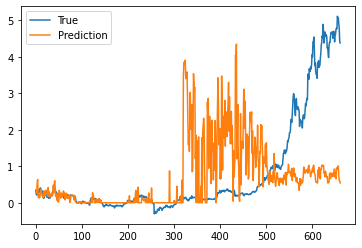

In [154]:
plt.plot(testY, label="True")
plt.plot(testPredict[:,3], label="Prediction")
plt.legend()
plt.show()

## XGBoost

In [36]:
import xgboost as xgb
import numpy as np

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [38]:
learning_rate = np.arange(0.0, 1.0, 0.1)
max_depth = [3,6,8,10,12]
n_estimators = [10, 100, 1000]
#mae, mse

In [39]:
res = []
for lr in learning_rate:
    for md in max_depth:
        for ne in n_estimators:
            print("Model XGBoost with learning rate: {} , max depth: {} and estimators {}".format(lr, md, ne))
            xgb_regressor = xgb.XGBRegressor(learning_rate=lr, max_depth=md, n_estimators=ne)
            xgb_regressor.fit(X_train, y_train)
            y_pred = xgb_regressor.predict(X_test)
            print("Accuracy in train: {}".format(xgb_regressor.score(X_train, y_train)))
            print("Accuracy in test: {}".format(xgb_regressor.score(X_test, y_test)))
            print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
            print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
            print("---------------------")
            res.append({"lr": lr, "md":md, "ne":ne, "xgb": xgb_regressor, "mse": mean_squared_error(y_test, y_pred), "mae":mean_absolute_error(y_test, y_pred)})

Model XGBoost with learning rate: 0.0 , max depth: 3 and estimators 10
Accuracy in train: -1.2016362372187745
Accuracy in test: -46.66357322438122
MSE: 72912428.7010422
MAE: 8448.828205980066
---------------------
Model XGBoost with learning rate: 0.0 , max depth: 3 and estimators 100
Accuracy in train: -1.2016362372187745
Accuracy in test: -46.66357322438122
MSE: 72912428.7010422
MAE: 8448.828205980066
---------------------
Model XGBoost with learning rate: 0.0 , max depth: 3 and estimators 1000
Accuracy in train: -1.2016362372187745
Accuracy in test: -46.66357322438122
MSE: 72912428.7010422
MAE: 8448.828205980066
---------------------
Model XGBoost with learning rate: 0.0 , max depth: 6 and estimators 10
Accuracy in train: -1.2016362372187745
Accuracy in test: -46.66357322438122
MSE: 72912428.7010422
MAE: 8448.828205980066
---------------------
Model XGBoost with learning rate: 0.0 , max depth: 6 and estimators 100
Accuracy in train: -1.2016362372187745
Accuracy in test: -46.66357322

Accuracy in train: 0.999999999999358
Accuracy in test: 0.9864776898440621
MSE: 20685.492262125725
MAE: 99.9296858129153
---------------------
Model XGBoost with learning rate: 0.2 , max depth: 10 and estimators 10
Accuracy in train: 0.9700349941391818
Accuracy in test: 0.415132158774552
MSE: 894690.2610958532
MAE: 923.5012486373547
---------------------
Model XGBoost with learning rate: 0.2 , max depth: 10 and estimators 100
Accuracy in train: 0.9999999939212524
Accuracy in test: 0.9849843648429671
MSE: 22969.87728204957
MAE: 108.378235504049
---------------------
Model XGBoost with learning rate: 0.2 , max depth: 10 and estimators 1000
Accuracy in train: 0.9999999999996219
Accuracy in test: 0.9849812019500263
MSE: 22974.71565631408
MAE: 108.39199659987543
---------------------
Model XGBoost with learning rate: 0.2 , max depth: 12 and estimators 10
Accuracy in train: 0.9700349941391818
Accuracy in test: 0.415132158774552
MSE: 894690.2610958532
MAE: 923.5012486373547
-------------------

Accuracy in train: 0.9999367792371961
Accuracy in test: 0.9649775828473733
MSE: 53574.864846113254
MAE: 178.46318404796511
---------------------
Model XGBoost with learning rate: 0.5 , max depth: 3 and estimators 1000
Accuracy in train: 0.9999999999480433
Accuracy in test: 0.9649436034798307
MSE: 53626.8441260049
MAE: 179.85847468075167
---------------------
Model XGBoost with learning rate: 0.5 , max depth: 6 and estimators 10
Accuracy in train: 0.9997072693467044
Accuracy in test: 0.9395007921631704
MSE: 92547.49233983047
MAE: 231.59760602678574
---------------------
Model XGBoost with learning rate: 0.5 , max depth: 6 and estimators 100
Accuracy in train: 0.9999999742045825
Accuracy in test: 0.9429882049103007
MSE: 87212.69018223282
MAE: 222.1238523930648
---------------------
Model XGBoost with learning rate: 0.5 , max depth: 6 and estimators 1000
Accuracy in train: 0.999999999999964
Accuracy in test: 0.9430025295829211
MSE: 87190.7772915189
MAE: 222.10155691964286
----------------

Accuracy in train: 0.9999999999999819
Accuracy in test: 0.9693793834865211
MSE: 46841.29550696245
MAE: 171.04801624792358
---------------------
Model XGBoost with learning rate: 0.7000000000000001 , max depth: 10 and estimators 10
Accuracy in train: 0.999992530487715
Accuracy in test: 0.9567183839017874
MSE: 66209.2145918373
MAE: 206.77787349460132
---------------------
Model XGBoost with learning rate: 0.7000000000000001 , max depth: 10 and estimators 100
Accuracy in train: 0.9999999999999821
Accuracy in test: 0.9565472381440081
MSE: 66471.02150259545
MAE: 207.18380048276575
---------------------
Model XGBoost with learning rate: 0.7000000000000001 , max depth: 10 and estimators 1000
Accuracy in train: 0.9999999999999821
Accuracy in test: 0.9565472381440081
MSE: 66471.02150259545
MAE: 207.18380048276575
---------------------
Model XGBoost with learning rate: 0.7000000000000001 , max depth: 12 and estimators 10
Accuracy in train: 0.9999979136737309
Accuracy in test: 0.9511830471099637


In [40]:
X_train.columns.values

array(['Open', 'Volume', 'NumberTransactions', 'Close SP500',
       'Open SP500', 'halving', 'Close Gold', 'Open Gold', 'OpenDJ',
       'CloseDJ', 'MA_3', 'EMA_3', 'Momentum_3', 'BollingerB_3',
       'Bollinger%b_3', 'S0k_3', 'RSI_3', 'CCI_3', 'STD_3', 'MA_5',
       'EMA_5', 'Momentum_5', 'BollingerB_5', 'Bollinger%b_5', 'S0k_5',
       'RSI_5', 'CCI_5', 'STD_5', 'MA_8', 'EMA_8', 'Momentum_8',
       'BollingerB_8', 'Bollinger%b_8', 'S0k_8', 'RSI_8', 'CCI_8',
       'STD_8', 'MA_10', 'EMA_10', 'Momentum_10', 'BollingerB_10',
       'Bollinger%b_10', 'S0k_10', 'RSI_10', 'CCI_10', 'STD_10'],
      dtype=object)

In [41]:
xgb_regressor.feature_importances_

array([3.65476226e-05, 9.02260672e-06, 3.97149415e-05, 1.11324980e-05,
       6.77863572e-05, 0.00000000e+00, 1.36182862e-05, 4.01978696e-07,
       3.90132307e-04, 2.91341184e-05, 6.00429019e-03, 9.91003990e-01,
       1.32711342e-04, 1.91108538e-05, 1.65082238e-05, 1.90897536e-05,
       7.71099167e-06, 1.63303303e-05, 1.07978840e-05, 7.27896077e-06,
       4.69364277e-05, 6.98294680e-05, 1.81281648e-05, 2.32937819e-05,
       0.00000000e+00, 9.54626885e-05, 5.87710929e-05, 4.17934571e-05,
       5.14494022e-04, 2.45361698e-05, 1.21110888e-05, 7.18523552e-06,
       3.45407534e-05, 0.00000000e+00, 2.12615669e-06, 1.10131994e-04,
       1.49591278e-05, 1.07022252e-05, 2.69367547e-06, 3.06480979e-05,
       8.39304630e-06, 9.53921233e-04, 0.00000000e+00, 1.02280810e-05,
       3.03388697e-06, 7.07780346e-05], dtype=float32)

<ipython-input-42-4c6c1ab6c7fa>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_train.columns.values, rotation='vertical')


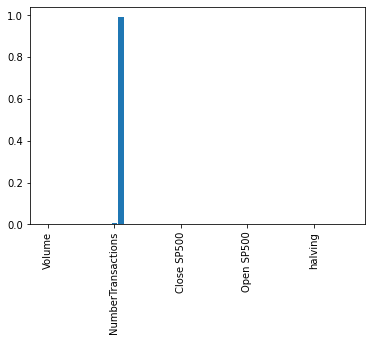

In [42]:
fig, ax = plt.subplots()
p1 = ax.bar(range(len(xgb_regressor.feature_importances_)), xgb_regressor.feature_importances_)
ax.set_xticklabels(X_train.columns.values, rotation='vertical')
plt.show()

## SVM

In [467]:
from sklearn.svm import SVR

In [468]:
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [469]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
cs = [0.8, 0.9, 1, 1.1, 1.2]
epsilon = [0.001, 0.01, 0.1, 1]

In [470]:
res = []
for k in kernel:
    for c in cs:
        for e in epsilon:
            print("Model SVR with kernel: {} , C: {} and epsilon {}".format(k, c, e))
            svr = SVR(kernel=k, C=c, epsilon=e)
            svr.fit(X_train, y_train)
            y_pred = svr.predict(X_test)
            print("Accuracy in train: {}".format(svr.score(X_train, y_train)))
            print("Accuracy in test: {}".format(svr.score(X_test, y_test)))
            print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
            print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
            print("---------------------")
            res.append({"kernel": k, "C":c, "epsilon":e, "svr": svr, "mse": mean_squared_error(y_test, y_pred), "mae":mean_absolute_error(y_test, y_pred)})

Model SVR with kernel: linear , C: 0.8 and epsilon 0.001
Accuracy in train: 0.2022342884052577
Accuracy in test: -4.9320154417221325
MSE: 10431529.964267861
MAE: 2974.5688789918445
---------------------
Model SVR with kernel: linear , C: 0.8 and epsilon 0.01
Accuracy in train: 0.20223563472495654
Accuracy in test: -4.932048287453749
MSE: 10431587.723934356
MAE: 2974.578044824313
---------------------
Model SVR with kernel: linear , C: 0.8 and epsilon 0.1
Accuracy in train: 0.20224909726706397
Accuracy in test: -4.932376751155356
MSE: 10432165.331828192
MAE: 2974.669703149012
---------------------
Model SVR with kernel: linear , C: 0.8 and epsilon 1
Accuracy in train: 0.20238365719898666
Accuracy in test: -4.935662026689425
MSE: 10437942.533609137
MAE: 2975.5862863892053
---------------------
Model SVR with kernel: linear , C: 0.9 and epsilon 0.001
Accuracy in train: 0.2211680992082683
Accuracy in test: -4.96484366324887
MSE: 10489258.839031272
MAE: 2985.480760688732
-------------------

Accuracy in train: 0.02879054560050942
Accuracy in test: -4.752347318261777
MSE: 10115581.12159992
MAE: 2913.027180729082
---------------------
Model SVR with kernel: rbf , C: 0.8 and epsilon 0.1
Accuracy in train: 0.02879054560050942
Accuracy in test: -4.752347318261777
MSE: 10115581.12159992
MAE: 2913.027180729082
---------------------
Model SVR with kernel: rbf , C: 0.8 and epsilon 1
Accuracy in train: 0.02879054560050942
Accuracy in test: -4.752347318261777
MSE: 10115581.12159992
MAE: 2913.027180729082
---------------------
Model SVR with kernel: rbf , C: 0.9 and epsilon 0.001
Accuracy in train: 0.03232414371379866
Accuracy in test: -4.7558579114801125
MSE: 10121754.54759808
MAE: 2914.642225607036
---------------------
Model SVR with kernel: rbf , C: 0.9 and epsilon 0.01
Accuracy in train: 0.03232414371379866
Accuracy in test: -4.7558579114801125
MSE: 10121754.54759808
MAE: 2914.642225607036
---------------------
Model SVR with kernel: rbf , C: 0.9 and epsilon 0.1
Accuracy in train

ValueError: Precomputed matrix must be a square matrix. Input is a 1204x8 matrix.

## Catboost

### Model Definition

In [63]:
# https://catboost.ai/docs/search/?query=catboostregressor
model = CatBoostRegressor(iterations=20_000,
                          verbose=100, 
                          # boosting_type = 'Ordered',
                          early_stopping_rounds=200,
                          loss_function = 'RMSE',
                          custom_metric = 'MAE',
                          task_type = 'GPU'
                          )

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model = True)

Learning rate set to 0.016534
0:	learn: 9607.0392120	test: 25040.0930350	best: 25040.0930350 (0)	total: 24.2ms	remaining: 8m 3s
100:	learn: 2727.5228642	test: 13623.7774263	best: 13623.7774263 (100)	total: 1.75s	remaining: 5m 45s
200:	learn: 1297.0890745	test: 10555.8818637	best: 10555.8818637 (200)	total: 3.49s	remaining: 5m 43s
300:	learn: 1020.4821401	test: 9847.7534331	best: 9847.7534331 (300)	total: 5.2s	remaining: 5m 40s
400:	learn: 970.9755988	test: 9715.3259544	best: 9715.3259544 (400)	total: 7.03s	remaining: 5m 43s
500:	learn: 941.4713677	test: 9682.8927909	best: 9679.3557472 (472)	total: 8.61s	remaining: 5m 35s
600:	learn: 908.6315872	test: 9564.2973438	best: 9564.2973438 (600)	total: 10.2s	remaining: 5m 30s
700:	learn: 833.3369994	test: 9581.3472122	best: 9558.0619960 (602)	total: 11.8s	remaining: 5m 24s
800:	learn: 802.1769540	test: 9646.0203607	best: 9558.0619960 (602)	total: 13.4s	remaining: 5m 21s
bestTest = 9558.061996
bestIteration = 602
Shrink model to first 603 itera

### Hyper Parameter Tuning

In [32]:
model_hyp = CatBoostRegressor(                          
                          early_stopping_rounds=100,
                          loss_function = 'RMSE',
                          custom_metric = 'MAE',
                          task_type = 'GPU'
                          )
grid = {
    'boosting_type': ['Ordered', 'Plain'],
    'learning_rate': [0.003, 0.006, 0.009, 0.03, 0.1, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [33]:
X_train_cv = pd.concat([X_train, X_valid])
y_train_cv = pd.concat([y_train, y_valid])
X_train_cv = X_train_cv[:360]
y_train_cv = y_train_cv[:360]

In [34]:
print("Train", X_train_cv.shape, y_train_cv.shape)

Train (134, 82) (134,)


In [35]:
grid_search_results = model_hyp.grid_search(grid, X_train_cv, y_train_cv, verbose=True)

Streaming output truncated to the last 5000 lines.
232:	learn: 12121.4081166	test: 14872.1330060	best: 14872.1330060 (232)	total: 2.24s	remaining: 7.38s
233:	learn: 12082.6042622	test: 14832.2700842	best: 14832.2700842 (233)	total: 2.25s	remaining: 7.38s
234:	learn: 12041.5507928	test: 14783.8787874	best: 14783.8787874 (234)	total: 2.27s	remaining: 7.38s
235:	learn: 11999.7172802	test: 14735.8458994	best: 14735.8458994 (235)	total: 2.28s	remaining: 7.39s
236:	learn: 11950.8570310	test: 14692.2288756	best: 14692.2288756 (236)	total: 2.3s	remaining: 7.39s
237:	learn: 11920.0117418	test: 14657.9154498	best: 14657.9154498 (237)	total: 2.31s	remaining: 7.4s
238:	learn: 11878.0789032	test: 14614.6503867	best: 14614.6503867 (238)	total: 2.33s	remaining: 7.43s
239:	learn: 11840.0622378	test: 14574.3135179	best: 14574.3135179 (239)	total: 2.35s	remaining: 7.44s
240:	learn: 11803.5046530	test: 14534.7245002	best: 14534.7245002 (240)	total: 2.36s	remaining: 7.44s
241:	learn: 11757.1209903	test: 1

In [36]:
grid_search_results

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

### Use hyper parameters

In [37]:
model1 = CatBoostRegressor(                          
    early_stopping_rounds=100,
    verbose=100, 
    boosting_type = 'Plain',
    depth =  4,
    l2_leaf_reg =  7,
    learning_rate =  0.03,
    loss_function = 'RMSE',
    custom_metric = 'MAE',
    task_type = 'GPU'
    )

model1.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model = True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10649.4827815	test: 10895.0658217	best: 10895.0658217 (0)	total: 8.57ms	remaining: 8.57s
100:	learn: 1745.9902046	test: 2281.1979959	best: 2281.1979959 (100)	total: 486ms	remaining: 4.32s
200:	learn: 571.9824845	test: 1146.6956069	best: 1146.6956069 (200)	total: 947ms	remaining: 3.76s
300:	learn: 340.3538703	test: 911.0475046	best: 911.0475046 (300)	total: 1.36s	remaining: 3.15s
400:	learn: 262.6154041	test: 825.7236557	best: 825.7236557 (400)	total: 1.76s	remaining: 2.63s
500:	learn: 200.5753057	test: 782.1452929	best: 782.1452929 (500)	total: 2.23s	remaining: 2.23s
600:	learn: 161.3757153	test: 753.8414953	best: 753.8414953 (600)	total: 2.63s	remaining: 1.75s
700:	learn: 127.8839098	test: 741.1096285	best: 741.1096285 (700)	total: 3.1s	remaining: 1.32s
800:	learn: 108.6317087	test: 729.8251186	best: 729.6943297 (796)	total: 3.49s	remaining: 867ms
900:	learn: 91.0933138	test: 722.2326751	best: 722.2326751 (900)	total: 3.88s	remaining: 426ms
999:	learn: 73.9910010	test: 716.2

### Save and Load Models

In [38]:
model.save_model('base_model_CPU.model')

In [39]:
model1.save_model('hyp_model1_GPU.model')

# Test

In [40]:
model_use = CatBoostRegressor()
model_use.load_model('hyp_model1_GPU.model')

In [41]:
%%time
y_pred = model_use.predict(X_train)
mse_train = mean_squared_error(y_train,y_pred)
print('mean_squared_error train', math.sqrt(mse_train))
mae_train = mean_absolute_error(y_train,y_pred)
print('mean_absolute_error train', mae_train)

y_pred = model_use.predict(X_valid)
mse_valid = mean_squared_error(y_valid,y_pred)
print('mean_squared_error valid', math.sqrt(mse_valid))
mae_valid = mean_absolute_error(y_valid,y_pred)
print('mean_absolute_error valid', mae_valid)

y_pred = model_use.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred)
print('mean_squared_error test', math.sqrt(mse_test))
mae_test = mean_absolute_error(y_test,y_pred)
print('mean_absolute_error test', mae_test)

mean_squared_error train 74.22837876756968
mean_absolute_error train 60.14576764885674
mean_squared_error valid 716.1750947878938
mean_absolute_error valid 476.7030793163981
mean_squared_error test 6504.01671928628
mean_absolute_error test 6163.386067811367
CPU times: user 15.7 ms, sys: 706 µs, total: 16.4 ms
Wall time: 15.4 ms


# Strategy Tester

In [42]:
%%time 
X_test_unscaled = scaler.inverse_transform(X_test)
X_test_unscaled = pd.DataFrame(X_test_unscaled, columns=X_test.columns)

CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 914 µs


In [43]:
X_test_unscaled['Pred_Close'] = y_pred
X_test_unscaled['Close'] = y_test.values

In [44]:
X_test_unscaled = X_test_unscaled[['Open', 'Close', 'Pred_Close']]

In [45]:
X_test_unscaled['Diff'] = X_test_unscaled['Close'] - X_test_unscaled['Open']
X_test_unscaled['Change'] = X_test_unscaled['Diff'] / X_test_unscaled['Open']
X_test_unscaled['Buy'] = X_test_unscaled['Pred_Close'] > X_test_unscaled['Close']

In [46]:
# Bitcoin alınması gereken günler
X_test_unscaled[X_test_unscaled['Buy'] == True]

Empty DataFrame
Columns: [Open, Close, Pred_Close, Diff, Change, Buy]
Index: []

In [47]:
# Bitcoin satılması gereken günler
X_test_unscaled[X_test_unscaled['Buy'] == False]

Open     Close    Pred_Close     Diff    Change    Buy
0   47800.05  50256.27  47404.682031  2456.22  0.051385  False
1   50256.27  49225.61  46232.724699 -1030.66 -0.020508  False
2   49240.70  46757.95  43744.111381 -2482.75 -0.050421  False
3   46757.97  47821.80  44528.981173  1063.83  0.022752  False
4   47834.24  49139.11  45448.977874  1304.87  0.027279  False
5   49139.11  48473.55  43633.752438  -665.56 -0.013544  False
6   48473.55  48864.73  43679.422910   391.18  0.008070  False
7   48862.06  48903.96  43658.808288    41.90  0.000858  False
8   48886.76  48375.96  42192.952546  -510.80 -0.010449  False
9   48379.72  45499.08  40459.843225 -2880.64 -0.059542  False
10  45499.08  45966.89  40901.523641   467.81  0.010282  False
11  45961.63  44416.49  39835.723276 -1545.14 -0.033618  False
12  44408.95  43645.11  39727.194148  -763.84 -0.017200  False
13  43640.52  46750.85  42415.257439  3110.33  0.071272  False
14  46736.59  47354.32  42666.062105   617.73  0.013217  False
15  47353.82  47361.09  42660.962317     7.27  0.000154  False
16  47362.20  48900.09  44085.999840  1537.89  0.032471  False
17  48924.11  50150.08  44755.669997  1225.97  0.025059  False
18  50160.29  50051.22  44297.712636  -109.07 -0.002174  False
19  50051.23  49929.11  42998.192838  -122.12 -0.002440  False
20  49926.22  50123.42  43246.725521   197.20  0.003950  False
21  50123.41  48788.28  41095.648429 -1335.13 -0.026637  False
22  48788.28  49581.49  41969.134998   793.21  0.016258  False
23  49577.65  50006.23  42367.809826   428.58  0.008645  False
24  50006.22  48979.49  40252.876890 -1026.73 -0.020532  False
25  48977.81  47366.99  39839.171493 -1610.82 -0.032889  False
26  47367.48  48818.22  40942.244154  1450.74  0.030627  False
27  48817.12  48970.74  40283.767497   153.62  0.003147  False
28  48970.74  50161.53  41839.300440  1190.79  0.024316  False
29  50175.89  50394.44  41850.837212   218.55  0.004356  False
30  50389.37  50205.78  40437.598041  -183.59 -0.003643  False
31  50205.78  53177.79  43659.281823  2972.01  0.059197  False
32  53187.44  52642.53  43381.992250  -544.91 -0.010245  False
33  52635.25  53181.60  44191.730317   546.35  0.010380  False

## Plot Accuracy

In [48]:
#https://matplotlib.org/

figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(X_test_unscaled[['Close','Pred_Close']])
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Close', 'Prediction'])
plt.title('Close vs Predicted Close')
plt.grid(True)

plt.tight_layout()
plt.show()

ImportError: ignored

<Figure size 960x800 with 1 Axes>

## Simulation

In [49]:
Init_Balance = 10_000
Ratio = 1
Balance = Init_Balance
BalanceGraph = []
last_order = False
SellCount = 0
BuyCount = 0
AccurateMove = 0
GrossLoss = 0
GrossGain = 0
CommisionRatio = 0
Commision = 0 

In [50]:
%%time
for index, row in tqdm(X_test_unscaled.iterrows()):
  buy = row.Buy
  change = row.Change

  if (buy):
    Balance += change * Balance * Ratio
    BuyCount += 1
    if (change > 0):
      AccurateMove += 1
      GrossGain += abs(change * Balance * Ratio)
    else:
      GrossLoss += abs(change * Balance * Ratio)
  else:
    Balance += -change * Balance * Ratio
    SellCount += 1
    if (change < 0):
      AccurateMove += 1
      GrossGain += abs(change * Balance * Ratio)
    else:
      GrossLoss += abs(change * Balance * Ratio)

  if (last_order != buy):
    Balance -= CommisionRatio * abs(change * Balance * Ratio)
    Commision += CommisionRatio * abs(change * Balance * Ratio)

  last_order = buy

  BalanceGraph.append(Balance)

34it [00:00, 8496.56it/s]

CPU times: user 9.65 ms, sys: 0 ns, total: 9.65 ms
Wall time: 11 ms


In [51]:
print("Balance", Balance)
print(f"Sell:{round(SellCount)}, Buy:{round(BuyCount)}, Sell Ratio: {(SellCount / (SellCount + BuyCount))}, Buy Ratio: {(BuyCount / (SellCount + BuyCount))}")
print(f"Accuracy: {AccurateMove / (SellCount + BuyCount)}")
print(f"Gross Loss:{round(GrossLoss)}, GrossGain:{round(GrossGain)}")

Balance 8750.038038598472
Sell:34, Buy:0, Sell Ratio: 1.0, Buy Ratio: 0.0
Accuracy: 0.4117647058823529
Gross Loss:4034, GrossGain:3054


In [52]:
figure(num=None, figsize = (12, 8), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(X_test_unscaled[['Close','Pred_Close']])
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Close', 'Prediction'])
plt.title('Close vs Predicted Close')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(BalanceGraph)
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Balance'])
plt.title('Balance')
plt.grid(True)

plt.tight_layout()
plt.show()

ImportError: ignored

<Figure size 960x640 with 2 Axes>